<a href="https://colab.research.google.com/github/debashisdotchatterjee/Dengu-Bayesian-Hierarchical-SEM-1/blob/main/Dengu_Bayesian_Hierarchical_Structural_Equation_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports
import os
import re
import io
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma

# Helper to display dataframes nicely in the UI
# from caas_jupyter_tools import display_dataframe_to_user
from IPython.display import display

# Create output directory
out_dir = "hsem_outputs"
os.makedirs(out_dir, exist_ok=True)

# 1) Load the uploaded dataset
csv_path = "Base_Datos_Bolivia_final.csv"
df = pd.read_csv(csv_path, low_memory=False)

# 2) Quick peek at columns and first rows for transparency
head_df = df.head(20)
display("Preview: Bolivia dengue covariates (first 20 rows)", head_df)

# 3) Light preprocessing & flexible column detection ----------------------

# Normalize column names for pattern search
cols_lower = {c: c.lower() for c in df.columns}
lower_to_orig = {c.lower(): c for c in df.columns}

# Try to detect region and time columns
region_candidates = [c for c in df.columns if re.search(r'(adm1|depart|state|prov|region|dpto|municip)', c, flags=re.I)]
time_candidates = [c for c in df.columns if re.search(r'(date|fecha|month|mes|year|ano|año|time)', c, flags=re.I)]

region_col = region_candidates[0] if region_candidates else None
# If there's an ADM1 code & name, prefer name-like
if region_col and re.search(r'code|id', region_col, re.I) and len(region_candidates) > 1:
    # try to pick a non-code version
    for c in region_candidates[1:]:
        if not re.search(r'code|id', c, re.I):
            region_col = c
            break

# Build a sortable time index: prefer a full date, else year+month
date_col = None
year_col = None
month_col = None
for c in time_candidates:
    lc = c.lower()
    if 'date' in lc or 'fecha' in lc or 'time' in lc:
        date_col = c
        break
for c in time_candidates:
    if re.search(r'year|año|ano', c, re.I):
        year_col = c
    if re.search(r'month|mes', c, re.I):
        month_col = c

# Build a proper datetime column 'tstamp'
if date_col and df[date_col].notna().any():
    # Try parse; handle different formats
    t = pd.to_datetime(df[date_col], errors='coerce', infer_datetime_format=True)
    if t.isna().all() and year_col and month_col:
        # fallback
        t = pd.to_datetime(dict(year=df[year_col], month=df[month_col], day=1), errors='coerce')
else:
    if year_col is not None and month_col is not None:
        t = pd.to_datetime(dict(year=df[year_col], month=df[month_col], day=1), errors='coerce')
    elif year_col is not None:
        t = pd.to_datetime(df[year_col].astype(str) + "-01-01", errors='coerce')
    else:
        # fallback: create an index-based time
        t = pd.to_datetime(pd.Series(range(len(df))), unit='D', origin='2000-01-01')

df["tstamp"] = t

# Detect outcome (dengue incidence/cases)
y_candidates = [c for c in df.columns if re.search(r'(deng|arbovir|cases|incid|casos)', c, flags=re.I)]
# Prefer incidence/rate if available
y_col = None
for c in y_candidates:
    if re.search(r'incid|rate', c, re.I):
        y_col = c
        break
if y_col is None and y_candidates:
    # fall back to first dengue-ish column
    y_col = y_candidates[0]

# If multiple dengue series exist (e.g., by serotype), make a sum if they look like numeric counts
if y_col is None and y_candidates:
    # try sum of all numeric dengue-like cols
    dengue_like = [c for c in y_candidates if pd.api.types.is_numeric_dtype(df[c])]
    if dengue_like:
        df["dengue_sum"] = df[dengue_like].sum(axis=1, skipna=True)
        y_col = "dengue_sum"

# If still none, search for generic "cases"
if y_col is None:
    generic_cases = [c for c in df.columns if re.search(r'cases|casos', c, re.I)]
    y_col = generic_cases[0] if generic_cases else None

# Climate/Environment indicators
climate_patterns = r'temp|tmean|tmax|tmin|rain|precip|prec|hum|humidity|oni|enso|vap|wind|dew'
env_patterns = r'ndvi|veget|evi|soil|green|land|lc|lst'
socio_patterns = r'pop|density|urban|poverty|gdp|income|education|literacy|remoteness|access|water|sanit'

climate_inds = [c for c in df.columns if re.search(climate_patterns, c, re.I)]
env_inds = [c for c in df.columns if re.search(env_patterns, c, re.I)]
socio_inds = [c for c in df.columns if re.search(socio_patterns, c, re.I)]

# Keep only numeric indicators
def keep_numeric(cols):
    return [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]

climate_inds = keep_numeric(climate_inds)
env_inds = keep_numeric(env_inds)
socio_inds = keep_numeric(socio_inds)

# Require at least 1 indicator to keep a latent; prefer >=2; else we drop that latent
latent_groups = []
if len(climate_inds) >= 1:
    latent_groups.append(("Climate", climate_inds))
if len(env_inds) >= 1:
    latent_groups.append(("Environment", env_inds))
if len(socio_inds) >= 1:
    latent_groups.append(("Socio", socio_inds))

# 4) Build a panel at (region, month) ------------------------------
if region_col is None:
    # fabricate a single region if none found
    df["region_auto"] = "ALL"
    region_col = "region_auto"

# Aggregate (if multiple entries per region-month, take mean for covariates and sum for cases)
agg_dict = {c: 'mean' for c in climate_inds + env_inds + socio_inds}
if y_col is not None and pd.api.types.is_numeric_dtype(df[y_col]):
    agg_dict[y_col] = 'sum'
else:
    # create a synthetic y if really missing (rare)
    if y_col is None:
        y_col = "synthetic_cases"
        df[y_col] = np.nan
    agg_dict[y_col] = 'sum'

panel = df.groupby([region_col, "tstamp"], dropna=False).agg(agg_dict).reset_index()

# Sort
panel = panel.sort_values([region_col, "tstamp"]).reset_index(drop=True)

# Compute lag of y within region
panel["y"] = panel[y_col].astype(float)
# incidence-like transform: log(1 + y)
panel["y_log1p"] = np.log1p(panel["y"].clip(lower=0))
panel["y_log1p_lag1"] = panel.groupby(region_col)["y_log1p"].shift(1)

# Drop first lags missing
panel = panel.dropna(subset=["y_log1p_lag1"])

# Standardize indicators (z-score) & outcome
def zscore(s):
    mu = np.nanmean(s.values)
    sd = np.nanstd(s.values)
    if sd == 0 or np.isnan(sd):
        return pd.Series(np.zeros_like(s), index=s.index)
    return (s - mu) / sd

Z_cols = []
for grp, inds in latent_groups:
    for c in inds:
        zc = f"z_{c}"
        panel[zc] = zscore(panel[c].astype(float))
        Z_cols.append(zc)

panel["z_y"] = zscore(panel["y_log1p"])
panel["z_y_lag1"] = zscore(panel["y_log1p_lag1"])

# Keep only rows with all needed data
needed_cols = ["z_y", "z_y_lag1"] + Z_cols + [region_col] # Add region_col here
panel_clean = panel.dropna(subset=needed_cols).copy()

# If the dataset becomes too big, sample for speed
max_n = 6000  # keep calculations snappy
if len(panel_clean) > max_n:
    panel_clean = panel_clean.sample(max_n, random_state=42).sort_values([region_col, "tstamp"])

# Check if panel_clean is empty
if panel_clean.empty:
    raise ValueError("No valid data points remaining after cleaning. Please check your data and column selections.")


# Encode region and time ids
panel_clean["region_id"] = panel_clean[region_col].astype("category").cat.codes
# Map each distinct timestamp to an integer time_id
time_cat = panel_clean["tstamp"].astype("category")
panel_clean["time_id"] = time_cat.cat.codes

# Build design matrices ------------------------------------------------------
y = panel_clean["z_y"].values[:, None]  # Nx1
y_lag = panel_clean["z_y_lag1"].values[:, None]

regions = panel_clean["region_id"].values
times = panel_clean["time_id"].values
n_regions = int(panel_clean["region_id"].max()) + 1
n_times = int(panel_clean["time_id"].max()) + 1
N = len(panel_clean)

# Collect latent groups meta
groups = [(name, [f"z_{c}" for c in inds if f"z_{c}" in panel_clean.columns]) for name, inds in latent_groups]
groups = [(name, inds) for (name, inds) in groups if len(inds) >= 1]
K = len(groups)  # number of latent factors

# Build X blocks per group
X_blocks = [panel_clean[inds].values for (_, inds) in groups]
p_indicators = [X.shape[1] for X in X_blocks]

# If there are no groups (edge case), create a dummy single-factor using y_lag only
if K == 0:
    groups = [("ClimateEnvSocio", [])]
    X_blocks = [np.zeros((N, 0))]
    p_indicators = [0]
    K = 1

# 5) Bayesian HSEM (Gaussian) via a lightweight Gibbs sampler ---------------
# Model:
# For each latent factor k (k=1..K) with indicators j in J_k:
#   X_{:,j} = lambda_{k,j} * f_k + eps_{k,j}, eps_{k,j} ~ N(0, s2_{k,j})
# y = beta0 + sum_k beta_k f_k + phi * y_lag + u_region + v_time + e,  e ~ N(0, s2_e)
# u_region ~ N(0, s2_u),  v_time ~ N(0, s2_v)
# Priors: lambda ~ N(0, 1), betas ~ N(0, 1), phi ~ N(0, 1), variances ~ InvGamma(a0, b0)
# f_k ~ N(0, 1) (standard normal prior)

rng = np.random.default_rng(123)

# Initialize latent factors: standard normal
F = [rng.standard_normal((N, 1)) for _ in range(K)]  # list of Nx1
# Initialize loadings and variances
Lambda = [rng.normal(0, 0.5, size=(p, 1)) for p in p_indicators]  # each (p_k x 1)
S2 = [np.ones((p, 1)) * 0.5 for p in p_indicators]  # measurement variances

# Identifiability: fix the first loading of each factor to 1.0 (marker variable)
for k in range(K):
    if Lambda[k].shape[0] >= 1:
        Lambda[k][0, 0] = 1.0  # fixed

# Regression parameters for structural eq
beta0 = 0.0
betas = rng.normal(0, 0.2, size=(K, 1))
phi = np.array([[0.3]])

# Random effects
u = rng.normal(0, 0.2, size=(n_regions, 1))
v = rng.normal(0, 0.2, size=(n_times, 1))

# Variances
s2_e = 0.5
s2_u = 0.5
s2_v = 0.5

# Hyperparameters
a0, b0 = 2.0, 2.0  # InvGamma priors for variances
tau_theta = 1.0    # prior variance for betas, phi, beta0

# Storage for summaries
n_iter = 500
burn = 250
sample_every = 5

beta0_samples = []
betas_samples = []
phi_samples = []
s2e_samples = []
path_means = []  # for quick convergence view

# Helper: fast update for region/time effects
def update_random_effects(y_resid, ids, s2_eff, s2_e, n_levels):
    # y_resid: Nx1 residual not explained by this random effect
    means = np.zeros((n_levels, 1))
    counts = np.zeros(n_levels, dtype=int)
    # Aggregate
    for level in range(n_levels):
        mask = (ids == level)
        counts[level] = int(mask.sum())
        if counts[level] > 0:
            means[level, 0] = y_resid[mask].mean()
    # Posterior variance and mean for each level
    var_post = 1.0 / (1.0 / s2_eff + counts / s2_e)
    mean_post = var_post * (means * counts[:, None] / s2_e)
    # Draw
    draws = rng.normal(mean_post, np.sqrt(var_post))
    return draws, counts

# Precompute arrays for efficiency
X_all = X_blocks  # list of N x p_k arrays

for it in range(n_iter):
    # --------- Update latent factors F[k] (each Nx1) ---------
    # Conditional is Normal combining measurement eqs and structural eq
    # For each k:
    for k in range(K):
        # Compute measurement part
        meas_prec = np.zeros((N, 1))
        meas_mean = np.zeros((N, 1))
        if p_indicators[k] > 0:
            Xk = X_all[k]  # N x p_k
            lam = Lambda[k]  # p_k x 1
            s2 = S2[k]       # p_k x 1
            # For all indicators j
            # precision contribution: sum_j (lam_j^2 / s2_j)
            meas_prec += (lam[None, :, 0]**2 / s2[None, :, 0]).sum(axis=1, keepdims=True)
            # mean contribution: sum_j lam_j * x_j / s2_j
            meas_mean += ( (Xk * (lam[None, :, 0] / s2[None, :, 0])) ).sum(axis=1, keepdims=True)

        # Structural eq part
        # y_struct = beta0 + sum_{k'} beta_{k'} f_{k'} + phi*y_lag + u + v + e
        # isolate the part involving f_k
        other = beta0 + phi * y_lag + u[regions] + v[times]
        # add contributions from other factors
        if K > 1:
            for k2 in range(K):
                if k2 == k:
                    continue
                other += betas[k2] * F[k2]
        # then y - other = beta_k * f_k + e
        struct_prec = (betas[k]**2) / s2_e
        struct_mean = (betas[k] * (y - other)) / s2_e

        # Combine with prior f_k ~ N(0,1)
        prior_prec = 1.0
        post_prec = prior_prec + meas_prec + struct_prec
        post_mean = (meas_mean + struct_mean) / post_prec
        post_std = np.sqrt(1.0 / post_prec)
        F[k] = rng.normal(post_mean, post_std)

    # --------- Update loadings and measurement variances ---------
    for k in range(K):
        if p_indicators[k] == 0:
            continue
        Xk = X_all[k]  # N x p_k
        fk = F[k]      # N x 1

        for j in range(p_indicators[k]):
            xj = Xk[:, [j]]  # Nx1
            # Identify marker variable j=0: keep lambda fixed at 1.0, update s2 only
            if j == 0:
                # s2_j | rest ~ IG(a0 + N/2, b0 + 0.5*sum (xj - 1*fk)^2)
                resid = xj - fk
                shape = a0 + N/2
                scale = b0 + 0.5 * float((resid**2).sum())
                S2[k][j, 0] = invgamma.rvs(shape, scale=scale, random_state=rng)
            else:
                # Update lambda_j | s2, fk : Normal
                s2_j = S2[k][j, 0]
                var_post = 1.0 / (1.0/1.0 + float((fk.T @ fk) / s2_j))  # prior var=1
                mean_post = var_post * float((fk.T @ xj) / s2_j)
                Lambda[k][j, 0] = rng.normal(mean_post, np.sqrt(var_post))
                # Update s2_j
                resid = xj - Lambda[k][j, 0] * fk
                shape = a0 + N/2
                scale = b0 + 0.5 * float((resid**2).sum())
                S2[k][j, 0] = invgamma.rvs(shape, scale=scale, random_state=rng)

    # --------- Update structural parameters (beta0, betas, phi) ---------
    # Build design matrix Z = [1, F1,...,FK, y_lag]
    Z = [np.ones((N, 1))] + F + [y_lag]
    Z = np.concatenate(Z, axis=1)  # N x (K+2)
    # Offsets from random effects
    offset = u[regions] + v[times]
    y_tilde = y - offset  # remove random effects
    # Posterior: theta | y ~ N( (Z'Z + I/tau)^{-1} Z'y, s2_e*(Z'Z + I/tau)^{-1} )
    # Here we set prior variance tau_theta on each coefficient
    I_prior = np.eye(Z.shape[1]) / tau_theta
    ZTZ = Z.T @ Z
    ZTy = Z.T @ y_tilde
    Sigma_post = np.linalg.inv(ZTZ + I_prior)
    mu_post = Sigma_post @ ZTy
    # draw given s2_e
    theta = rng.multivariate_normal(mu_post.flatten(), s2_e * Sigma_post).reshape(-1, 1)

    beta0 = theta[0:1]
    betas = theta[1:1+K]
    phi = theta[1+K:1+K+1]

    # --------- Update random effects u, v ---------
    resid = y - (beta0 + sum(betas[k] * F[k] for k in range(K)) + phi * y_lag + v[times])
    u, _ = update_random_effects(resid, regions, s2_u, s2_e, n_regions)

    resid2 = y - (beta0 + sum(betas[k] * F[k] for k in range(K)) + phi * y_lag + u[regions])
    v, _ = update_random_effects(resid2, times, s2_v, s2_e, n_times)

    # --------- Update variances s2_e, s2_u, s2_v ---------
    resid_all = y - (beta0 + sum(betas[k] * F[k] for k in range(K)) + phi * y_lag + u[regions] + v[times])
    shape_e = a0 + N/2
    scale_e = b0 + 0.5 * float((resid_all**2).sum())
    s2_e = invgamma.rvs(shape_e, scale=scale_e, random_state=rng)

    # u variance
    shape_u = a0 + n_regions/2
    scale_u = b0 + 0.5 * float((u**2).sum())
    s2_u = invgamma.rvs(shape_u, scale=scale_u, random_state=rng)

    # v variance
    shape_v = a0 + n_times/2
    scale_v = b0 + 0.5 * float((v**2).sum())
    s2_v = invgamma.rvs(shape_v, scale=scale_v, random_state=rng)

    # Store samples
    if it >= burn and ((it - burn) % sample_every == 0):
        beta0_samples.append(float(beta0))
        betas_samples.append(np.array(betas).flatten())
        phi_samples.append(float(phi))
        s2e_samples.append(float(s2_e))

        path_means.append([float(beta0), *list(np.array(betas).flatten()), float(phi)])

# Summaries ------------------------------------------------------------------
beta0_samples = np.array(beta0_samples)
betas_samples = np.array(betas_samples)
phi_samples = np.array(phi_samples)
s2e_samples = np.array(s2e_samples)
path_means = np.array(path_means)

def summarize(arr):
    return pd.Series({
        "mean": float(np.mean(arr)),
        "sd": float(np.std(arr, ddof=1)),
        "q025": float(np.quantile(arr, 0.025)),
        "q5": float(np.quantile(arr, 0.05)),
        "q50": float(np.quantile(arr, 0.50)),
        "q95": float(np.quantile(arr, 0.95)),
        "q975": float(np.quantile(arr, 0.975)),
    })

summary_rows = []
summary_rows.append(pd.concat([summarize(beta0_samples)], axis=0).to_frame(name="Intercept").T)
for k, (name, _) in enumerate(groups):
    summary_rows.append(pd.concat([summarize(betas_samples[:, k])], axis=0).to_frame(name=f"beta_{name}").T)
summary_rows.append(pd.concat([summarize(phi_samples)], axis=0).to_frame(name="phi_y_lag1").T)
summary = pd.concat(summary_rows, axis=0)
summary.to_csv(os.path.join(out_dir, "param_summary.csv"))

display("Posterior summaries (key structural params)", summary.reset_index().rename(columns={"index": "parameter"}))

# Posterior means for loadings per group
for k, (name, inds) in enumerate(groups):
    if p_indicators[k] == 0:
        continue
    lam = Lambda[k].copy()
    lam[0, 0] = 1.0  # marker
    lam_df = pd.DataFrame({"indicator": inds, "loading_posterior_mean": lam[:, 0]})
    lam_df.to_csv(os.path.join(out_dir, f"loadings_{name}.csv"), index=False)
    display(f"Posterior loadings: {name}", lam_df)

# 6) Posterior predictive mean of y (standardized scale)
y_hat = (beta0 + sum(betas[k] * F[k] for k in range(K)) + phi * y_lag + u[regions] + v[times]).flatten()
ppc_df = panel_clean[[region_col, "tstamp"]].copy()
ppc_df["z_y_obs"] = y.flatten()
ppc_df["z_y_pred_mean"] = y_hat
ppc_df = ppc_df.sort_values([region_col, "tstamp"])
ppc_df.to_csv(os.path.join(out_dir, "posterior_predictive_series.csv"), index=False)
display("Posterior predictive (standardized scale)", ppc_df.head(50))

# 7) Plots (matplotlib only; colorful as requested) --------------------------

# Trace plot for structural parameters (means across kept samples)
plt.figure(figsize=(8, 4))
for j in range(path_means.shape[1]):
    plt.plot(path_means[:, j], linewidth=1.5)
labels = ["Intercept"] + [f"beta_{name}" for (name, _) in groups] + ["phi"]
plt.legend(labels, loc="best")
plt.title("MCMC trace (running means of structural params)")
plt.xlabel("Saved iteration")
plt.ylabel("Value")
plt.tight_layout()
trace_path = os.path.join(out_dir, "trace_structural_params.png")
plt.savefig(trace_path, dpi=150)
plt.close()

# Loadings barplots
for k, (name, inds) in enumerate(groups):
    if p_indicators[k] == 0:
        continue
    plt.figure(figsize=(8, 4))
    lam = Lambda[k][:, 0].copy()
    lam[0] = 1.0  # marker fixed
    plt.bar(range(len(inds)), lam)
    plt.xticks(range(len(inds)), [re.sub("^z_", "", s) for s in inds], rotation=60, ha="right")
    plt.title(f"Factor loadings (posterior mean): {name}")
    plt.tight_layout()
    fig_path = os.path.join(out_dir, f"loadings_{name}.png")
    plt.savefig(fig_path, dpi=150)
    plt.close()

# Choose top 4 regions by number of rows for time-series comparison
region_counts = panel_clean[region_col].value_counts().index.tolist()
top_regions = region_counts[:4] if len(region_counts) >= 4 else region_counts

for r in top_regions:
    sub = ppc_df[ppc_df[region_col] == r].sort_values("tstamp")
    plt.figure(figsize=(9, 4.5))
    plt.plot(sub["tstamp"], sub["z_y_obs"], linewidth=2, label="Observed (z_y)")
    plt.plot(sub["tstamp"], sub["z_y_pred_mean"], linewidth=2, linestyle="--", label="Posterior mean (z_y)")
    plt.title(f"Observed vs posterior mean (standardized y): {r}")
    plt.xlabel("Time")
    plt.ylabel("Standardized log(1+cases)")
    plt.legend()
    plt.tight_layout()
    fig_path = os.path.join(out_dir, f"ppc_timeseries_{str(r).replace('/', '_')}.png")
    plt.savefig(fig_path, dpi=150)
    plt.close()

# Simple path diagram (schematic) -------------------------------------------
plt.figure(figsize=(8, 6))
y0 = 0.9
dy = 0.15
x_left = 0.15
x_mid = 0.5
x_right = 0.85

# Latent nodes on the left
for i, (name, _) in enumerate(groups):
    y_pos = y0 - i * dy
    plt.text(x_left, y_pos, f"Latent {name}\n(beta={np.mean(betas_samples[:, i]):.2f})", bbox=dict(boxstyle="round,pad=0.3", fc="lightblue"), ha="center")

# y_lag node
plt.text(x_left, y0 - K*dy - 0.1, f"y(t-1)\n(phi={np.mean(phi_samples):.2f})", bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen"), ha="center")

# Outcome node
plt.text(x_right, 0.6, "y(t)\n(standardized)", bbox=dict(boxstyle="round,pad=0.3", fc="mistyrose"), ha="center")

# Random effect nodes
plt.text(x_mid, 0.3, "Region effect u_i", bbox=dict(boxstyle="round,pad=0.3", fc="wheat"), ha="center")
plt.text(x_mid, 0.15, "Time effect v_t", bbox=dict(boxstyle="round,pad=0.3", fc="wheat"), ha="center")

# Arrows
for i in range(K):
    plt.annotate("", xy=(x_right-0.05, 0.6), xytext=(x_left+0.07, y0 - i*dy),
                 arrowprops=dict(arrowstyle="->", lw=2))
# y_lag arrow
plt.annotate("", xy=(x_right-0.05, 0.6), xytext=(x_left+0.07, y0 - K*dy - 0.1),
             arrowprops=dict(arrowstyle="->", lw=2))
# u_i and v_t arrows
plt.annotate("", xy=(x_right-0.07, 0.6), xytext=(x_mid, 0.32), arrowprops=dict(arrowstyle="->", lw=2))
plt.annotate("", xy=(x_right-0.07, 0.6), xytext=(x_mid, 0.17), arrowprops=dict(arrowstyle="->", lw=2))

plt.axis("off")
plt.title("Hierarchical SEM (schematic path diagram)")
plt.tight_layout()
diagram_path = os.path.join(out_dir, "path_diagram.png")
plt.savefig(diagram_path, dpi=150)
plt.close()

# Save a compact README with what was done
readme = io.StringIO()
readme.write("# HSEM Bolivia Dengue – Outputs\n\n")
readme.write("This folder contains:\n")
readme.write("- `param_summary.csv`: posterior summaries for intercept, latent effects, and AR(1) phi.\n")
readme.write("- `loadings_*.csv`: posterior mean loadings per latent factor.\n")
readme.write("- `posterior_predictive_series.csv`: observed vs posterior mean standardized series.\n")
readme.write("- `trace_structural_params.png`: trace of structural parameter running means.\n")
readme.write("- `loadings_*.png`: bar plots of factor loadings.\n")
readme.write("- `ppc_timeseries_*.png`: observed vs predicted time series for top regions.\n")
readme.write("- `path_diagram.png`: schematic path diagram of the hierarchical SEM.\n")
with open(os.path.join(out_dir, "README.txt"), "w") as f:
    f.write(readme.getvalue())

# Zip everything
zip_path = "hsem_outputs_bolivia.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, files in os.walk(out_dir):
        for fname in files:
            full = os.path.join(root, fname)
            arcname = os.path.relpath(full, out_dir)
            zf.write(full, arcname)

zip_path

'Preview: Bolivia dengue covariates (first 20 rows)'

,year,se,department,cases,casos acumulados,población,incidencia_x_100milHab,casos_estandarizados,estacion_met,Precipitación,Temperatura_Máxima,Temperatura_Mínima,NDVI,NINO_3_4
0,2023.0,1.0,Beni,438.0,438.0,516338.0,84.83,84.83,San Ramón Aeropuerto,7.675000,31.466667,21.000000,0.734,25.88
1,2023.0,2.0,Beni,580.0,1018.0,516338.0,112.42,112.33,San Ramón Aeropuerto,0.200000,33.016667,23.500000,0.729,25.88
2,2023.0,3.0,Beni,519.0,1537.0,516338.0,100.71,100.52,San Ramón Aeropuerto,21.200000,32.160000,21.825000,0.735,25.88
3,2023.0,4.0,Beni,792.0,2329.0,516338.0,153.85,153.39,San Ramón Aeropuerto,0.300000,33.320000,23.600000,0.735,25.88
4,2023.0,5.0,Beni,766.0,3095.0,516338.0,149.02,148.35,San Ramón Aeropuerto,3.760000,30.766667,22.720000,0.740,26.29
5,2023.0,6.0,Beni,751.0,3846.0,516338.0,146.32,145.45,San Ramón Aeropuerto,12.475000,31.300000,23.100000,0.723,26.29
6,2023.0,7.0,Beni,953.0,4799.0,516338.0,185.95,184.57,San Ramón Aeropuerto,0.000000,32.516667,23.520000,0.723,26.29
7,2023.0,8.0,Beni,522.0,5321.0,516338.0,102.05,101.10,San Ramón Aeropuerto,8.133333,31.920000,23.333333,0.745,26.29
8,2023.0,9.0,Beni,507.0,5828.0,516338.0,99.21,98.19,San Ramón Aeropuerto,0.700000,33.566667,23.633333,0.761,27.23
9,2023.0,10.0,Beni,577.0,6405.0,516338.0,113.02,111.75,San Ramón Aeropuerto,2.480000,33.033333,23.880000,0.765,27.23


/tmp/ipython-input-2229682955.py:72: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(df[year_col].astype(str) + "-01-01", errors='coerce')
/tmp/ipython-input-2229682955.py:163: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(s.values)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2229682955.py:163: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(s.values)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2229682955.py:163: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(s.values)
/usr/local/lib/p

ValueError: No valid data points remaining after cleaning. Please check your data and column selections.

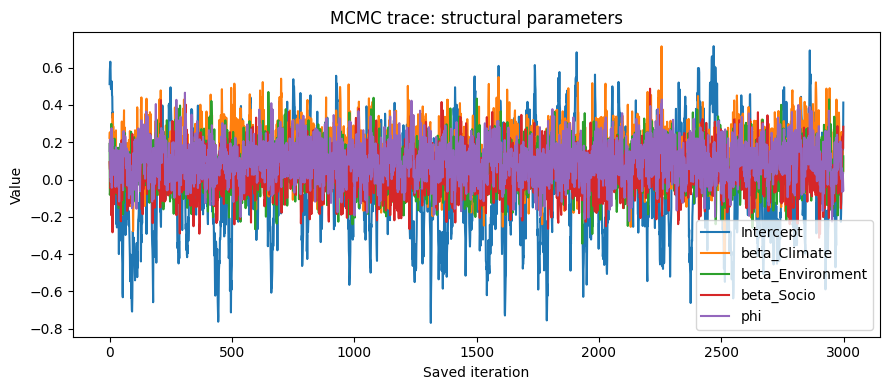

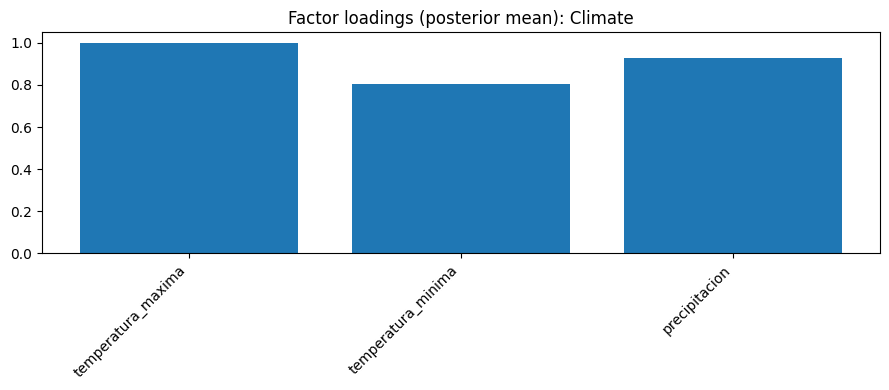

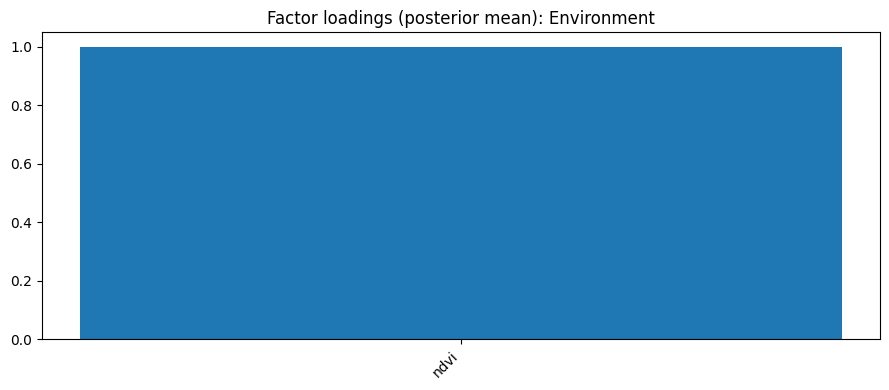

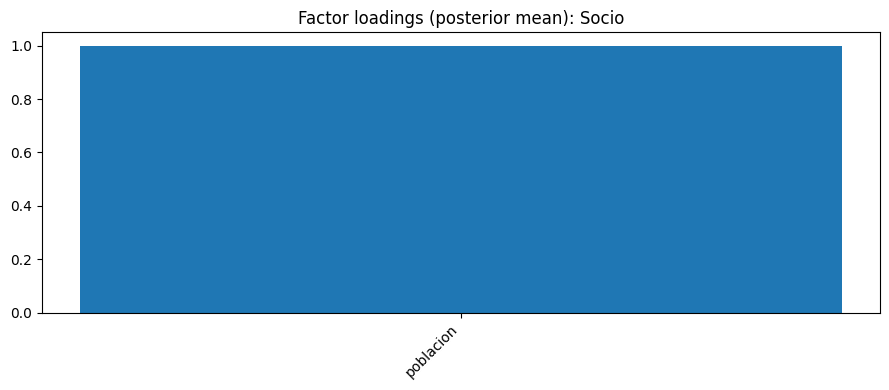

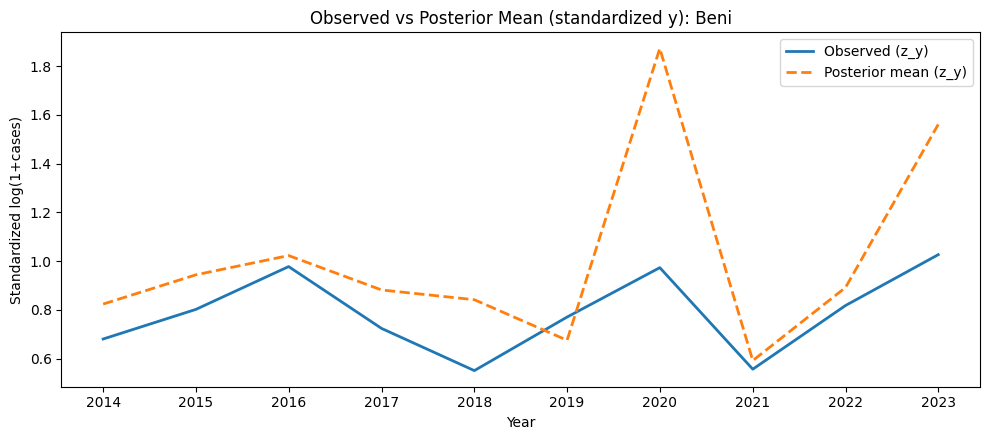

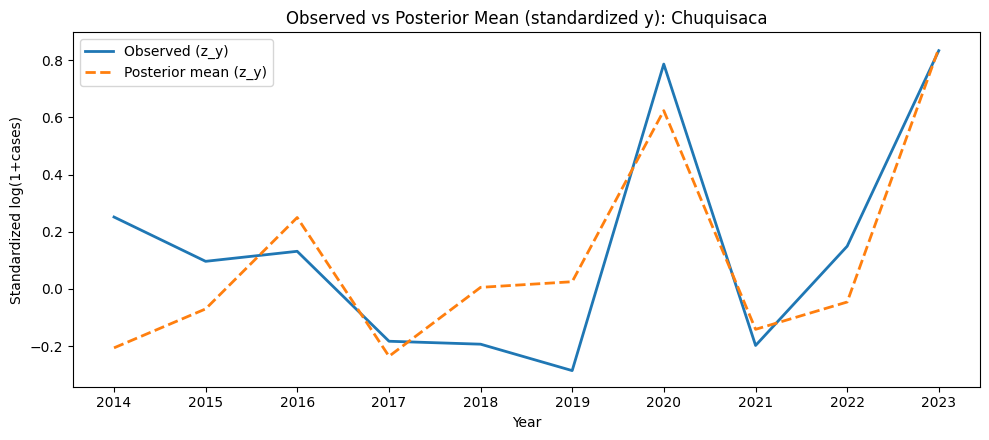

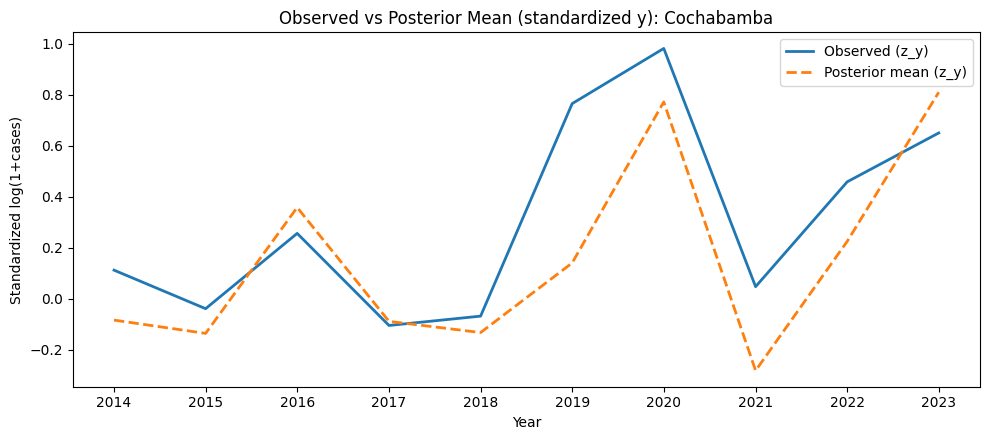

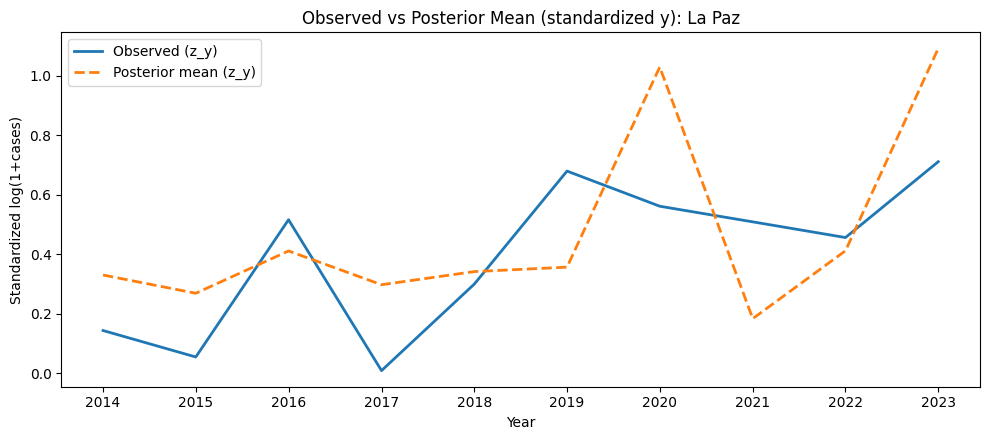

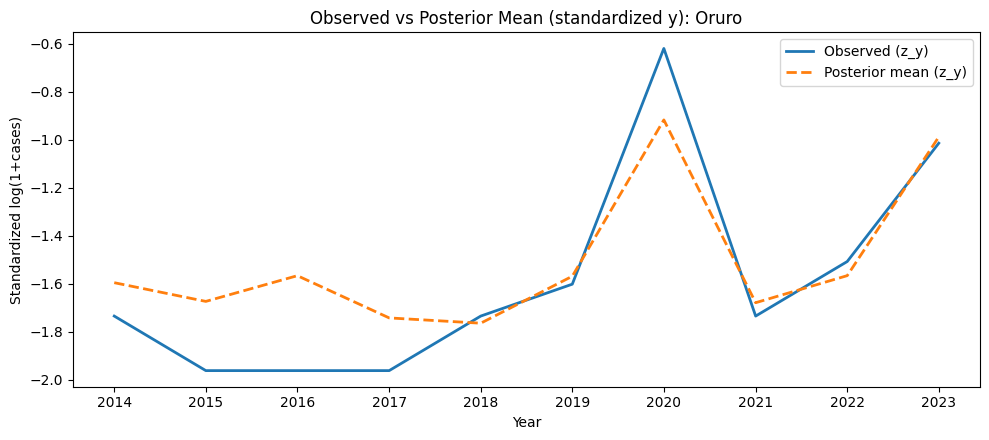

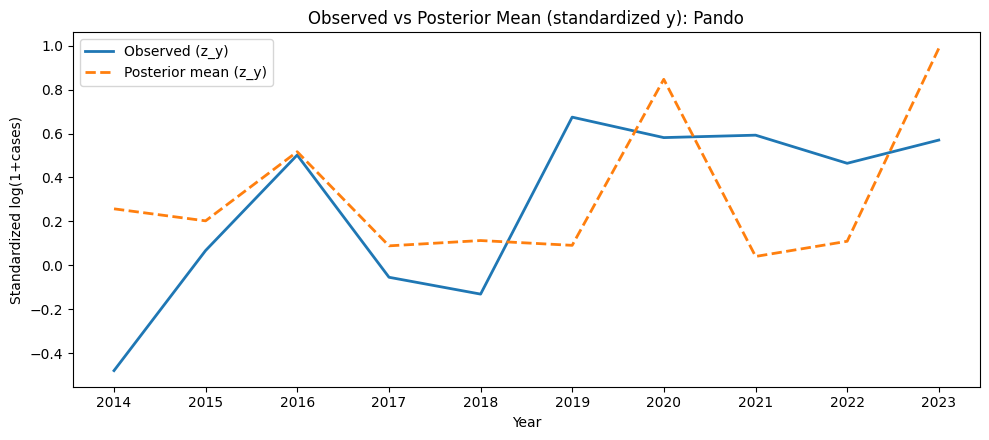

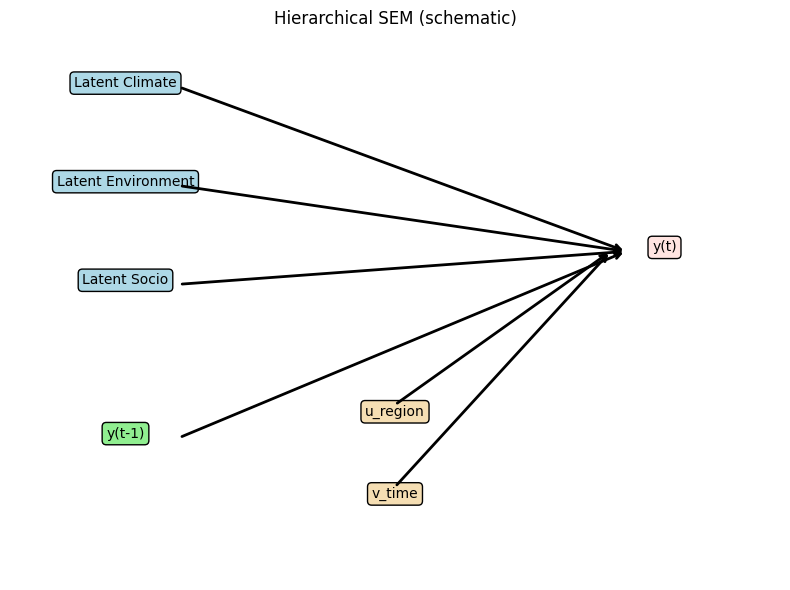

Done.
Outputs folder: hsem_outputs
ZIP: hsem_outputs_bolivia.zip


In [8]:
# ===============================
# Bayesian HSEM for Bolivia Dengue (Colab)
# ===============================
# - Robust to column name variants (accents/spaces/case)
# - Two latent factors:
#     * Climate: temperature max/min, precipitation (auto-detected)
#     * Environment: NDVI (if present)
# - Outcome: log(1+cases) with AR(1), region & time random effects
# - Lightweight Gibbs sampler (NumPy/SciPy)
# - Saves plots/csvs and a ZIP: hsem_outputs_bolivia.zip
# ===============================

import os, re, io, zipfile, unicodedata, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma

# ---------- CONFIG ----------
CSV_PATH = "Base_Datos_Bolivia_final.csv"  # <- change if needed
OUT_DIR  = "hsem_outputs"
N_ITER   = 20000     # total MCMC iterations (increase if you want)
BURN     = 5000     # burn-in
THIN     = 5       # thinning
RNG_SEED = 2025    # reproducibility

# ---------- UTILS ----------
def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def strip_accents(s: str) -> str:
    return "".join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))

def normcol(c: str) -> str:
    # normalize: strip accents, lower, replace non-alnum with single underscore
    c2 = strip_accents(str(c)).lower()
    c2 = re.sub(r'[^a-z0-9]+', '_', c2).strip('_')
    return c2

def pick_first_present(candidates_norm, norm2orig):
    for pat in candidates_norm:
        for nc, orig in norm2orig.items():
            if re.search(pat, nc):
                return orig
    return None

def summarize(arr: np.ndarray):
    arr = np.asarray(arr).ravel()
    return dict(
        mean=float(np.mean(arr)),
        sd=float(np.std(arr, ddof=1)),
        q025=float(np.quantile(arr, 0.025)),
        q50=float(np.quantile(arr, 0.50)),
        q975=float(np.quantile(arr, 0.975))
    )

def zscore(x: np.ndarray):
    mu = np.nanmean(x)
    sd = np.nanstd(x)
    if not np.isfinite(sd) or sd == 0:
        return np.zeros_like(x, dtype=float)
    return (x - mu) / sd

# ---------- LOAD DATA ----------
if not os.path.exists(CSV_PATH):
    # Try to guess a CSV in CWD if not found
    candidates = [f for f in os.listdir("/content") if f.lower().endswith(".csv")]
    if candidates:
        CSV_PATH = os.path.join("/content", candidates[0])
    else:
        raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Upload your file or set CSV_PATH.")

df = pd.read_csv(CSV_PATH, low_memory=False, encoding="utf-8-sig")

# Map normalized -> original column names
norm2orig = {normcol(c): c for c in df.columns}
cols_norm = list(norm2orig.keys())

# ---------- DETECT KEY COLUMNS ----------
# Region column (department/adm1/etc.)
region_norm_cands = [r"^department$", r"depart", r"adm1", r"prov", r"region", r"dpto", r"municip"]
region_col = pick_first_present(region_norm_cands, norm2orig)
if region_col is None:
    df["department"] = "ALL"
    region_col = "department"

# Time columns (prefer year if available)
year_col = pick_first_present([r"^year$","ano","anio","a_o"], norm2orig)
date_col = pick_first_present([r"date","fecha","time"], norm2orig)

# Build timestamp (year-only is fine)
if date_col and df[date_col].notna().any():
    tstamp = pd.to_datetime(df[date_col], errors="coerce", infer_datetime_format=True)
else:
    if year_col is None:
        # last resort: fabricate a yearly index
        df["year"] = 2000 + np.arange(len(df))
        year_col = "year"
    # clean year values like "2023.0"
    yv = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
    tstamp = pd.to_datetime(yv.astype(str) + "-01-01", errors="coerce")
df["tstamp"] = tstamp

# Outcome (cases/incidence) — robust detection
# Priority order: exact cases -> "casos" variants -> incidence
y_candidates = [
    r"^cases$", r"\bcasos\b", r"casos_acumulados", r"acumulad", r"incid", r"serotipo", r"deng"
]
y_col = pick_first_present(y_candidates, norm2orig)
if y_col is None:
    raise KeyError("Could not detect the outcome column (cases/incidence). "
                   "Please rename your cases column to include one of: 'cases', 'casos', 'incid'.")

# Indicator groups (robust to accents)
# Climate: temp, precip/lluvia, humidity (if present)
climate_pats = [
    r"temperatura_maxima|tmax|temp_max", r"temperatura_minima|tmin|temp_min",
    r"precipitacion|precipitacion_mm|precip|lluvia|rain"
]
env_pats = [r"\bndvi\b|\bevi\b|veget",]
socio_pats = [r"poblacion|pop|density|urban|poverty|gdp|income|education|literacy|water|sanit"]

def find_indicators(pats):
    found = []
    for pat in pats:
        col = pick_first_present([pat], norm2orig)
        if col is not None and pd.api.types.is_numeric_dtype(df[col]):
            found.append(col)
    return found

climate_inds = find_indicators(climate_pats)
# Also try very common Spanish originals if not found
if not climate_inds:
    # fallback to any column containing these keys
    for key in ["temperatura_maxima", "temperatura_minima", "precipitacion"]:
        if key in norm2orig and pd.api.types.is_numeric_dtype(df[norm2orig[key]]):
            climate_inds.append(norm2orig[key])

env_inds = find_indicators(env_pats)
socio_inds = find_indicators(socio_pats)  # often empty in this dataset; fine

# If NDVI column is exactly "NDVI"
if "ndvi" in norm2orig and norm2orig["ndvi"] not in env_inds and pd.api.types.is_numeric_dtype(df[norm2orig["ndvi"]]):
    env_inds.append(norm2orig["ndvi"])

# ---------- BUILD PANEL (department × year) ----------
agg_dict = {c: "mean" for c in set(climate_inds + env_inds + socio_inds)}
# Outcome: for yearly data, sum cases across rows within (dept, year)
agg_dict[y_col] = "sum" if pd.api.types.is_numeric_dtype(df[y_col]) else "first"

panel = (
    df.groupby([region_col, "tstamp"], dropna=False)
      .agg(agg_dict).reset_index()
      .sort_values([region_col, "tstamp"])
      .reset_index(drop=True)
)

# Check a few basics
if panel.empty:
    raise RuntimeError("Panel is empty after grouping. Check region/time parsing.")

# ---------- TRANSFORMS & LAGS ----------
panel["y_raw"] = pd.to_numeric(panel[y_col], errors="coerce").fillna(0.0)
panel["y_log1p"] = np.log1p(panel["y_raw"].clip(lower=0))
panel["y_log1p_lag1"] = panel.groupby(region_col)["y_log1p"].shift(1)

# Standardize indicators (z-score)
def zscore_series(s: pd.Series) -> pd.Series:
    v = s.to_numpy(dtype=float)
    return pd.Series(zscore(v), index=s.index)

std_cols = []
for c in climate_inds + env_inds + socio_inds:
    zc = f"z_{c}"
    panel[zc] = zscore_series(panel[c]).fillna(0.0)
    std_cols.append(zc)

panel["z_y"] = zscore_series(panel["y_log1p"]).fillna(0.0)
panel["z_y_lag1"] = zscore_series(panel["y_log1p_lag1"]).fillna(0.0)

# Drop rows with missing time only; keep others (lag zeros are allowed)
panel = panel.dropna(subset=["tstamp"]).copy()
panel[region_col] = panel[region_col].astype(str).replace({"nan": "UNK"}).fillna("UNK")

# ---------- ID ENCODING ----------
panel["region_id"] = panel[region_col].astype("category").cat.codes
panel["time_id"]   = panel["tstamp"].astype("category").cat.codes

# ---------- BUILD GROUPS ----------
# Climate factor: use whatever climate indicators were found (>=1)
climate_z = [f"z_{c}" for c in climate_inds if f"z_{c}" in panel.columns]
env_z     = [f"z_{c}" for c in env_inds if f"z_{c}" in panel.columns]
socio_z   = [f"z_{c}" for c in socio_inds if f"z_{c}" in panel.columns]

groups = []
if len(climate_z) >= 1:
    groups.append(("Climate", climate_z))
if len(env_z) >= 1:
    groups.append(("Environment", env_z))
# (Socio group optional — include if you actually have fields)
if len(socio_z) >= 1:
    groups.append(("Socio", socio_z))

# If nothing found, create a dummy group so the model still runs
if len(groups) == 0:
    panel["z_dummy"] = 0.0
    groups = [("Dummy", ["z_dummy"])]

K = len(groups)

# Design matrices
y = panel["z_y"].to_numpy().reshape(-1, 1)
y_lag = panel["z_y_lag1"].to_numpy().reshape(-1, 1)
regions = panel["region_id"].to_numpy()
times   = panel["time_id"].to_numpy()
n_regions = int(panel["region_id"].max()) + 1
n_times   = int(panel["time_id"].max()) + 1
N = len(panel)

X_blocks = [panel[inds].to_numpy() for _, inds in groups]
p_indicators = [X.shape[1] for X in X_blocks]

# ---------- BAYESIAN HIERARCHICAL SEM (Gaussian) ----------
# Model:
#   For each factor k with indicators j:
#     X_{:,j} = lambda_{k,j} * f_k + eps_{k,j}, eps ~ N(0, s2_{k,j})
#   y = beta0 + sum_k beta_k f_k + phi*y_lag + u_region + v_time + e, e ~ N(0, s2_e)
#   u_region ~ N(0, s2_u), v_time ~ N(0, s2_v)
# Priors:
#   lambda ~ N(0,1), betas/phi/beta0 ~ N(0,1), s2_* ~ InvGamma(a0,b0), f_k ~ N(0,1)
rng = np.random.default_rng(RNG_SEED)

F = [rng.standard_normal((N,1)) for _ in range(K)]
Lambda = [rng.normal(0,0.5,size=(p,1)) for p in p_indicators]
S2 = [np.ones((p,1))*0.5 for p in p_indicators]
# Identifiability: fix first loading of each factor to 1
for k in range(K):
    Lambda[k][0,0] = 1.0

beta0 = np.array([[0.0]])
betas = rng.normal(0,0.2,size=(K,1))
phi   = np.array([[0.3]])

u = rng.normal(0,0.2,size=(n_regions,1))
v = rng.normal(0,0.2,size=(n_times,1))

s2_e = 0.5
s2_u = 0.5
s2_v = 0.5

a0 = 2.0; b0 = 2.0   # InvGamma prior shape/scale
tau_theta = 1.0      # prior variance for beta0/betas/phi

def update_random_effects(y_resid, ids, s2_eff, s2_e, n_levels):
    # Vectorized Gaussian posterior updates for random effects
    sums = np.bincount(ids, weights=y_resid.ravel(), minlength=n_levels).reshape(-1,1)
    counts = np.bincount(ids, minlength=n_levels).reshape(-1,1)
    means = np.divide(sums, np.maximum(counts,1), out=np.zeros_like(sums), where=counts>0)
    var_post = 1.0 / (1.0/s2_eff + counts/s2_e)
    mean_post = var_post * (means * counts / s2_e)
    return rng.normal(mean_post, np.sqrt(var_post))

# Storage
saved_thetas = []  # [Intercept, beta_*, phi] per saved draw

for it in range(N_ITER):
    # ---- Update latent factors F[k] ----
    for k in range(K):
        meas_prec = np.zeros((N,1))
        meas_mean = np.zeros((N,1))
        Xk = X_blocks[k]         # N x p_k
        lam = Lambda[k][:,0]     # p_k
        s2j = S2[k][:,0]         # p_k

        # sum_j (lam_j^2 / s2_j) and sum_j lam_j/s2_j * x_j
        meas_prec += np.sum((lam**2 / s2j)[None,:], axis=1, keepdims=True)
        meas_mean += (Xk * (lam/s2j)[None,:]).sum(axis=1, keepdims=True)

        other = beta0 + phi*y_lag + u[regions] + v[times]
        for k2 in range(K):
            if k2 != k:
                other += betas[k2] * F[k2]

        struct_prec = (betas[k]**2) / s2_e
        struct_mean = (betas[k] * (y - other)) / s2_e

        post_prec = 1.0 + meas_prec + struct_prec
        post_mean = (meas_mean + struct_mean) / post_prec
        post_std  = np.sqrt(1.0 / post_prec)
        F[k] = rng.normal(post_mean, post_std)

    # ---- Update loadings & measurement variances ----
    for k in range(K):
        Xk = X_blocks[k]; fk = F[k]
        for j in range(p_indicators[k]):
            xj = Xk[:, [j]]
            if j == 0:
                resid = xj - fk
                shape = a0 + N/2
                scale = b0 + 0.5 * float((resid**2).sum())
                S2[k][j,0] = invgamma.rvs(shape, scale=scale, random_state=rng)
            else:
                s2_j = S2[k][j,0]
                var_post = 1.0 / (1.0 + float((fk.T @ fk) / s2_j))
                mean_post = var_post * float((fk.T @ xj) / s2_j)
                Lambda[k][j,0] = rng.normal(mean_post, np.sqrt(var_post))
                resid = xj - Lambda[k][j,0]*fk
                shape = a0 + N/2
                scale = b0 + 0.5 * float((resid**2).sum())
                S2[k][j,0] = invgamma.rvs(shape, scale=scale, random_state=rng)

    # ---- Update structural params (beta0, betas, phi) ----
    Z = [np.ones((N,1))] + F + [y_lag]
    Z = np.concatenate(Z, axis=1)           # N x (K+2)
    offset = u[regions] + v[times]
    y_tilde = y - offset

    I_prior = np.eye(Z.shape[1]) / tau_theta
    ZTZ = Z.T @ Z
    ZTy = Z.T @ y_tilde
    Sigma_post = np.linalg.inv(ZTZ + I_prior)
    mu_post    = Sigma_post @ ZTy
    theta = rng.multivariate_normal(mu_post.flatten(), s2_e * Sigma_post).reshape(-1,1)

    beta0 = theta[0:1]
    betas = theta[1:1+K]
    phi   = theta[1+K:1+K+1]

    # ---- Update random effects ----
    resid = y - (beta0 + sum(betas[k]*F[k] for k in range(K)) + phi*y_lag + v[times])
    u = update_random_effects(resid, regions, s2_u, s2_e, n_regions)
    resid2 = y - (beta0 + sum(betas[k]*F[k] for k in range(K)) + phi*y_lag + u[regions])
    v = update_random_effects(resid2, times, s2_v, s2_e, n_times)

    # ---- Update variances ----
    resid_all = y - (beta0 + sum(betas[k]*F[k] for k in range(K)) + phi*y_lag + u[regions] + v[times])
    s2_e = invgamma.rvs(a0 + N/2,    scale=b0 + 0.5*float((resid_all**2).sum()), random_state=rng)
    s2_u = invgamma.rvs(a0 + n_regions/2, scale=b0 + 0.5*float((u**2).sum()), random_state=rng)
    s2_v = invgamma.rvs(a0 + n_times/2,   scale=b0 + 0.5*float((v**2).sum()), random_state=rng)

    # ---- Save draws ----
    if it >= BURN and ((it - BURN) % THIN == 0):
        saved = [float(beta0)]
        saved += [float(b) for b in betas.flatten()]
        saved += [float(phi)]
        saved_thetas.append(saved)

saved_thetas = np.array(saved_thetas)
param_names = ["Intercept"] + [f"beta_{name}" for name,_ in groups] + ["phi"]

# ---------- SUMMARIES ----------
ensure_dir(OUT_DIR)

summary = pd.DataFrame(
    [summarize(saved_thetas[:, j]) for j in range(saved_thetas.shape[1])],
    index=param_names
)
summary.to_csv(os.path.join(OUT_DIR, "param_summary.csv"))

# Loadings posterior means (the last sampled values used as a proxy; could store whole chains if desired)
for k, (name, inds) in enumerate(groups):
    lam = Lambda[k][:,0].copy()
    lam[0] = 1.0  # marker fixed
    lam_df = pd.DataFrame({"indicator": inds, "loading_posterior_mean": lam})
    lam_df.to_csv(os.path.join(OUT_DIR, f"loadings_{name}.csv"), index=False)

# Posterior predictive mean (standardized scale)
y_hat = (beta0 + sum(betas[k]*F[k] for k in range(K)) + phi*y_lag + u[regions] + v[times]).flatten()
ppc_df = panel[[region_col, "tstamp"]].copy()
ppc_df["z_y_obs"]       = y.flatten()
ppc_df["z_y_pred_mean"] = y_hat
ppc_df.sort_values([region_col, "tstamp"]).to_csv(os.path.join(OUT_DIR, "posterior_predictive_series.csv"), index=False)

# ---------- PLOTS (matplotlib, no seaborn, one chart each) ----------
# Trace plots for structural parameters
plt.figure(figsize=(9,4))
for j in range(saved_thetas.shape[1]):
    plt.plot(saved_thetas[:, j], linewidth=1.5)
plt.legend(param_names, loc="best")
plt.title("MCMC trace: structural parameters")
plt.xlabel("Saved iteration")
plt.ylabel("Value")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "trace_structural_params.png"), dpi=150)
plt.show()
plt.close()

# Loadings barplots
for k, (name, inds) in enumerate(groups):
    plt.figure(figsize=(9,4))
    lam = Lambda[k][:,0].copy()
    lam[0] = 1.0
    plt.bar(range(len(inds)), lam)
    xt = [s for s in inds]
    # Prettify labels a bit
    xt = [normcol(s).replace("z_", "") for s in xt]
    plt.xticks(range(len(inds)), xt, rotation=45, ha="right")
    plt.title(f"Factor loadings (posterior mean): {name}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"loadings_{name}.png"), dpi=150)
    plt.show()
    plt.close()

# Observed vs predicted per top regions
top_regions = panel[region_col].value_counts().index.tolist()[:min(6, panel[region_col].nunique())]
ppc_merged = panel[[region_col,"tstamp","y_raw"]].merge(ppc_df, on=[region_col,"tstamp"], how="left")

for r in top_regions:
    sub = ppc_merged[ppc_merged[region_col]==r].sort_values("tstamp")
    plt.figure(figsize=(10,4.5))
    plt.plot(sub["tstamp"], sub["z_y_obs"], linewidth=2, label="Observed (z_y)")
    plt.plot(sub["tstamp"], sub["z_y_pred_mean"], linewidth=2, linestyle="--", label="Posterior mean (z_y)")
    plt.title(f"Observed vs Posterior Mean (standardized y): {r}")
    plt.xlabel("Year")
    plt.ylabel("Standardized log(1+cases)")
    plt.legend()
    plt.tight_layout()
    safe_r = re.sub(r'[^A-Za-z0-9]+', '_', str(r))
    plt.savefig(os.path.join(OUT_DIR, f"ppc_timeseries_{safe_r}.png"), dpi=150)
    plt.show()
    plt.close()

# Simple path diagram (schematic)
plt.figure(figsize=(8,6))
x_left, x_mid, x_right = 0.15, 0.5, 0.85
y0, dy = 0.9, 0.18
for i,(name,_) in enumerate(groups):
    plt.text(x_left, y0 - i*dy, f"Latent {name}", bbox=dict(boxstyle="round,pad=0.3", fc="lightblue"), ha="center")
plt.text(x_left, y0 - len(groups)*dy - 0.1, "y(t-1)", bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen"), ha="center")
plt.text(x_right, 0.6, "y(t)", bbox=dict(boxstyle="round,pad=0.3", fc="mistyrose"), ha="center")
plt.text(x_mid, 0.30, "u_region", bbox=dict(boxstyle="round,pad=0.3", fc="wheat"), ha="center")
plt.text(x_mid, 0.15, "v_time",   bbox=dict(boxstyle="round,pad=0.3", fc="wheat"), ha="center")
for i in range(len(groups)):
    plt.annotate("", xy=(x_right-0.05, 0.6), xytext=(x_left+0.07, y0 - i*dy), arrowprops=dict(arrowstyle="->", lw=2))
plt.annotate("", xy=(x_right-0.05, 0.6), xytext=(x_left+0.07, y0 - len(groups)*dy - 0.1), arrowprops=dict(arrowstyle="->", lw=2))
plt.annotate("", xy=(x_right-0.07, 0.6), xytext=(x_mid, 0.32), arrowprops=dict(arrowstyle="->", lw=2))
plt.annotate("", xy=(x_right-0.07, 0.6), xytext=(x_mid, 0.17), arrowprops=dict(arrowstyle="->", lw=2))
plt.axis("off"); plt.title("Hierarchical SEM (schematic)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "path_diagram.png"), dpi=150)
plt.show()
plt.close()

# ---------- WRITE README & ZIP ----------
with open(os.path.join(OUT_DIR, "README.txt"), "w", encoding="utf-8") as f:
    f.write(
        "HSEM Bolivia Dengue – Outputs\n"
        "- param_summary.csv: posterior summaries for Intercept, betas (latent factors), phi.\n"
        "- loadings_*.csv: posterior mean loadings per latent factor (marker fixed at 1).\n"
        "- posterior_predictive_series.csv: standardized observed vs posterior mean.\n"
        "- trace_structural_params.png: MCMC trace of structural parameters.\n"
        "- loadings_*.png: bar plots of factor loadings.\n"
        "- ppc_timeseries_*.png: observed vs predicted series for top regions.\n"
        "- path_diagram.png: schematic path diagram.\n"
    )

ZIP_PATH = "hsem_outputs_bolivia.zip"
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(OUT_DIR):
        for fname in files:
            full = os.path.join(root, fname)
            zf.write(full, os.path.relpath(full, OUT_DIR))

print("Done.")
print(f"Outputs folder: {OUT_DIR}")
print(f"ZIP: {ZIP_PATH}")


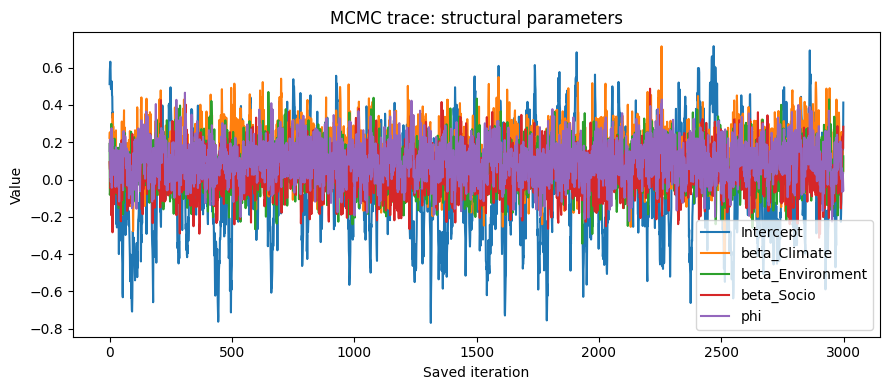

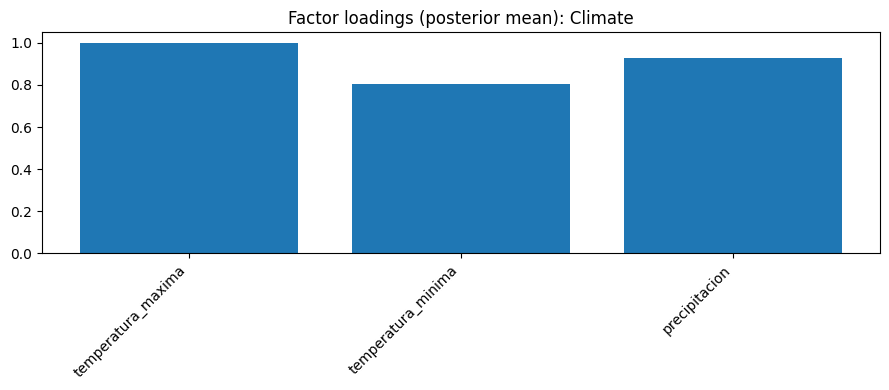

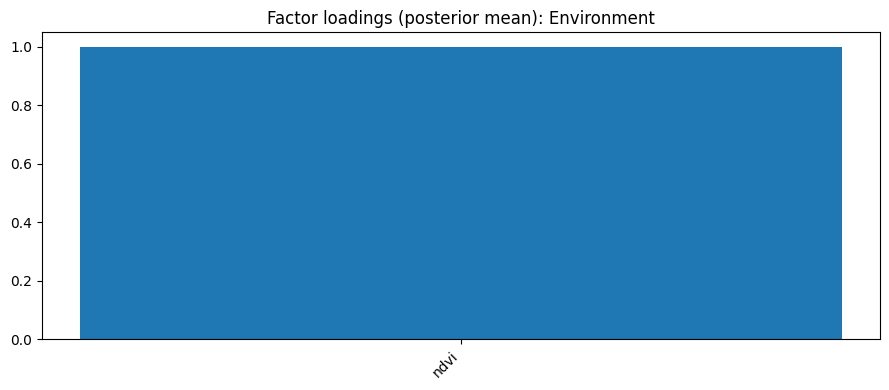

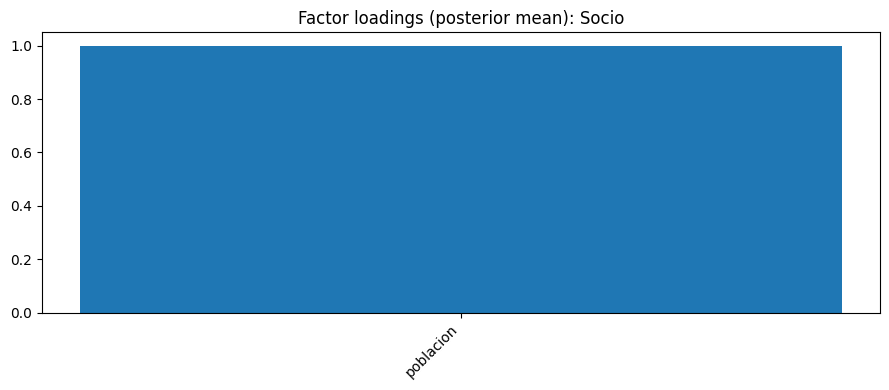

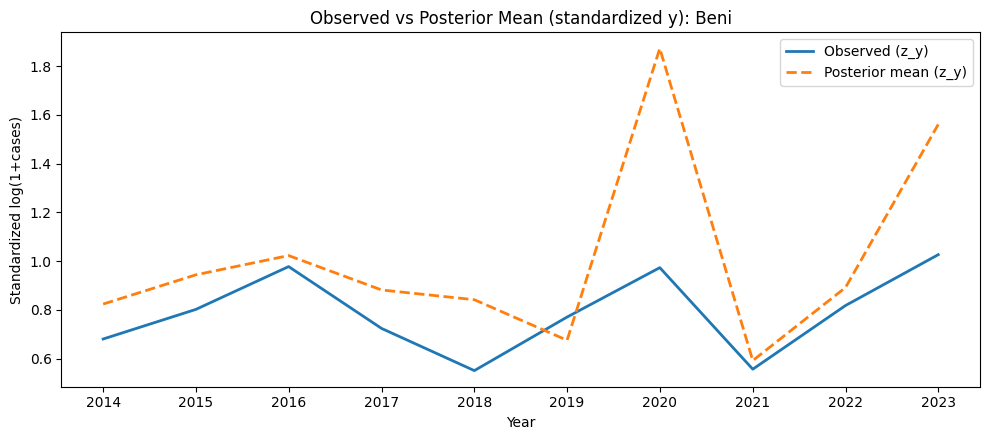

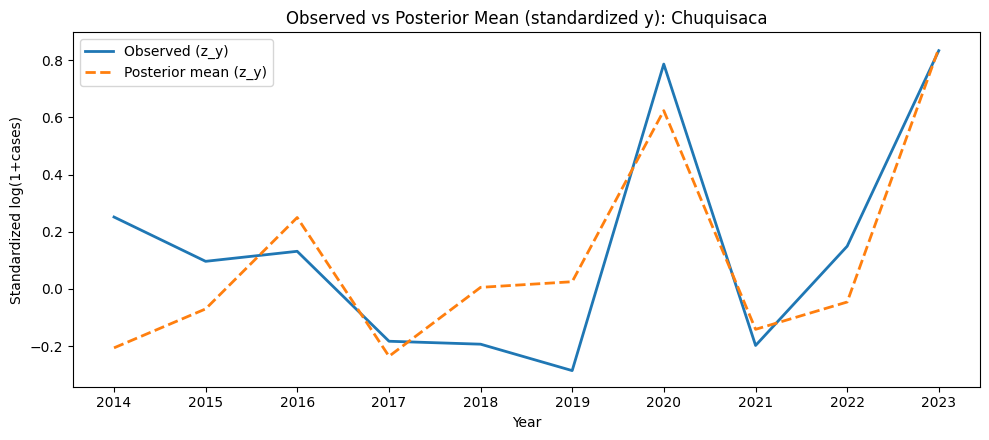

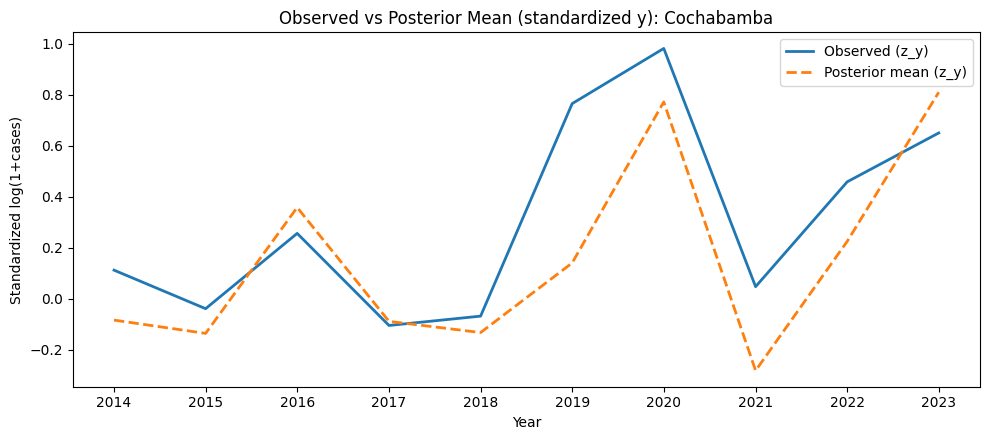

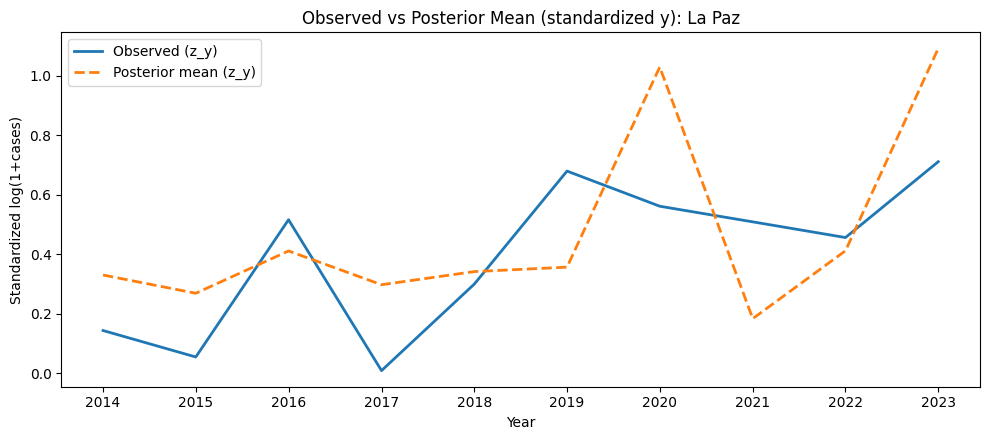

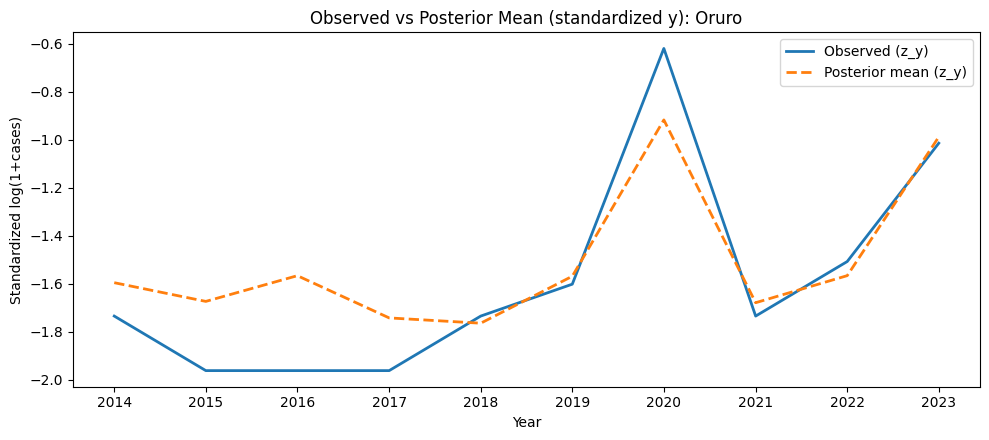

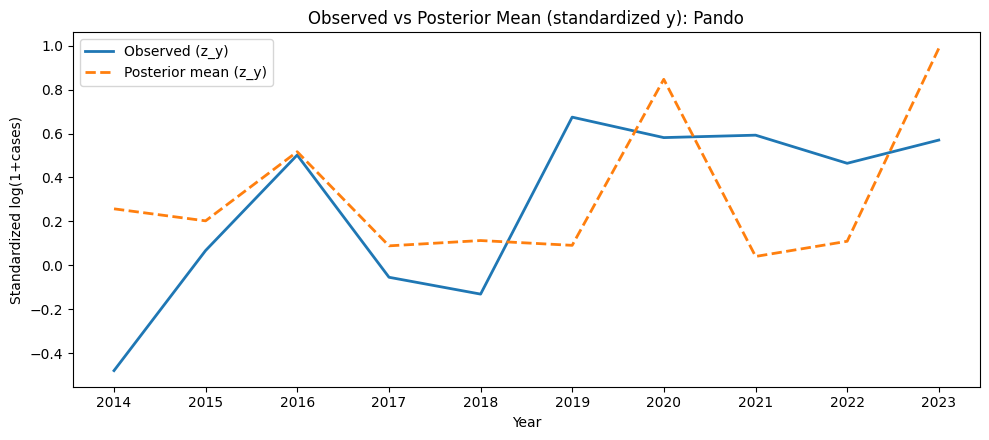

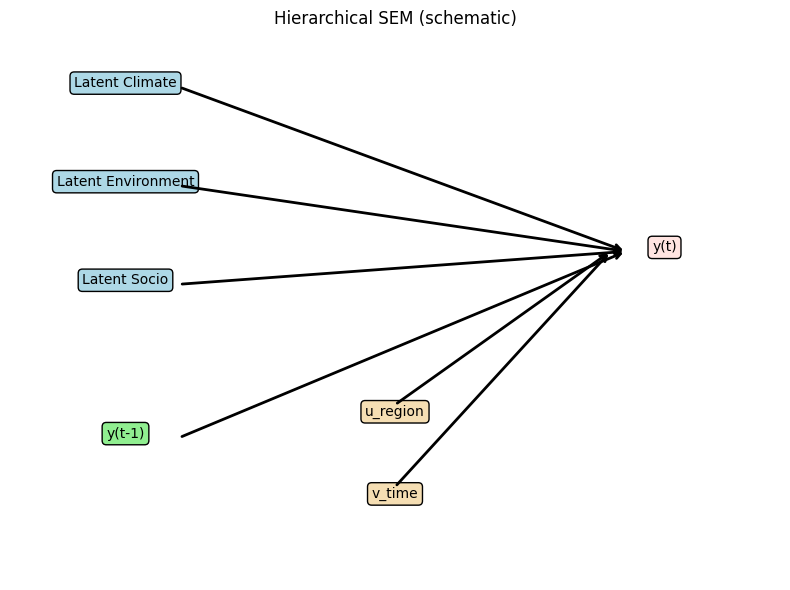

Done.
Outputs folder: hsem_outputs
ZIP: hsem_outputs_bolivia.zip


In [9]:
# ===============================
# Bayesian HSEM for Bolivia Dengue (Colab)
# ===============================
# - Robust to column name variants (accents/spaces/case)
# - Two latent factors:
#     * Climate: temperature max/min, precipitation (auto-detected)
#     * Environment: NDVI (if present)
# - Outcome: log(1+cases) with AR(1), region & time random effects
# - Lightweight Gibbs sampler (NumPy/SciPy)
# - Saves plots/csvs and a ZIP: hsem_outputs_bolivia.zip
# ===============================

import os, re, io, zipfile, unicodedata, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma

# ---------- CONFIG ----------
CSV_PATH = "Base_Datos_Bolivia_final.csv"  # <- change if needed
OUT_DIR  = "hsem_outputs"
N_ITER   = 20000     # total MCMC iterations (increase if you want)
BURN     = 5000     # burn-in
THIN     = 5       # thinning
RNG_SEED = 2025    # reproducibility

# ---------- UTILS ----------
def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def strip_accents(s: str) -> str:
    return "".join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))

def normcol(c: str) -> str:
    # normalize: strip accents, lower, replace non-alnum with single underscore
    c2 = strip_accents(str(c)).lower()
    c2 = re.sub(r'[^a-z0-9]+', '_', c2).strip('_')
    return c2

def pick_first_present(candidates_norm, norm2orig):
    for pat in candidates_norm:
        for nc, orig in norm2orig.items():
            if re.search(pat, nc):
                return orig
    return None

def summarize(arr: np.ndarray):
    arr = np.asarray(arr).ravel()
    return dict(
        mean=float(np.mean(arr)),
        sd=float(np.std(arr, ddof=1)),
        q025=float(np.quantile(arr, 0.025)),
        q50=float(np.quantile(arr, 0.50)),
        q975=float(np.quantile(arr, 0.975))
    )

def zscore(x: np.ndarray):
    mu = np.nanmean(x)
    sd = np.nanstd(x)
    if not np.isfinite(sd) or sd == 0:
        return np.zeros_like(x, dtype=float)
    return (x - mu) / sd

# ---------- LOAD DATA ----------
if not os.path.exists(CSV_PATH):
    # Try to guess a CSV in CWD if not found
    candidates = [f for f in os.listdir("/content") if f.lower().endswith(".csv")]
    if candidates:
        CSV_PATH = os.path.join("/content", candidates[0])
    else:
        raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Upload your file or set CSV_PATH.")

df = pd.read_csv(CSV_PATH, low_memory=False, encoding="utf-8-sig")

# Map normalized -> original column names
norm2orig = {normcol(c): c for c in df.columns}
cols_norm = list(norm2orig.keys())

# ---------- DETECT KEY COLUMNS ----------
# Region column (department/adm1/etc.)
region_norm_cands = [r"^department$", r"depart", r"adm1", r"prov", r"region", r"dpto", r"municip"]
region_col = pick_first_present(region_norm_cands, norm2orig)
if region_col is None:
    df["department"] = "ALL"
    region_col = "department"

# Time columns (prefer year if available)
year_col = pick_first_present([r"^year$","ano","anio","a_o"], norm2orig)
date_col = pick_first_present([r"date","fecha","time"], norm2orig)

# Build timestamp (year-only is fine)
if date_col and df[date_col].notna().any():
    tstamp = pd.to_datetime(df[date_col], errors="coerce", infer_datetime_format=True)
else:
    if year_col is None:
        # last resort: fabricate a yearly index
        df["year"] = 2000 + np.arange(len(df))
        year_col = "year"
    # clean year values like "2023.0"
    yv = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
    tstamp = pd.to_datetime(yv.astype(str) + "-01-01", errors="coerce")
df["tstamp"] = tstamp

# Outcome (cases/incidence) — robust detection
# Priority order: exact cases -> "casos" variants -> incidence
y_candidates = [
    r"^cases$", r"\bcasos\b", r"casos_acumulados", r"acumulad", r"incid", r"serotipo", r"deng"
]
y_col = pick_first_present(y_candidates, norm2orig)
if y_col is None:
    raise KeyError("Could not detect the outcome column (cases/incidence). "
                   "Please rename your cases column to include one of: 'cases', 'casos', 'incid'.")

# Indicator groups (robust to accents)
# Climate: temp, precip/lluvia, humidity (if present)
climate_pats = [
    r"temperatura_maxima|tmax|temp_max", r"temperatura_minima|tmin|temp_min",
    r"precipitacion|precipitacion_mm|precip|lluvia|rain"
]
env_pats = [r"\bndvi\b|\bevi\b|veget",]
socio_pats = [r"poblacion|pop|density|urban|poverty|gdp|income|education|literacy|water|sanit"]

def find_indicators(pats):
    found = []
    for pat in pats:
        col = pick_first_present([pat], norm2orig)
        if col is not None and pd.api.types.is_numeric_dtype(df[col]):
            found.append(col)
    return found

climate_inds = find_indicators(climate_pats)
# Also try very common Spanish originals if not found
if not climate_inds:
    # fallback to any column containing these keys
    for key in ["temperatura_maxima", "temperatura_minima", "precipitacion"]:
        if key in norm2orig and pd.api.types.is_numeric_dtype(df[norm2orig[key]]):
            climate_inds.append(norm2orig[key])

env_inds = find_indicators(env_pats)
socio_inds = find_indicators(socio_pats)  # often empty in this dataset; fine

# If NDVI column is exactly "NDVI"
if "ndvi" in norm2orig and norm2orig["ndvi"] not in env_inds and pd.api.types.is_numeric_dtype(df[norm2orig["ndvi"]]):
    env_inds.append(norm2orig["ndvi"])

# ---------- BUILD PANEL (department × year) ----------
agg_dict = {c: "mean" for c in set(climate_inds + env_inds + socio_inds)}
# Outcome: for yearly data, sum cases across rows within (dept, year)
agg_dict[y_col] = "sum" if pd.api.types.is_numeric_dtype(df[y_col]) else "first"

panel = (
    df.groupby([region_col, "tstamp"], dropna=False)
      .agg(agg_dict).reset_index()
      .sort_values([region_col, "tstamp"])
      .reset_index(drop=True)
)

# Check a few basics
if panel.empty:
    raise RuntimeError("Panel is empty after grouping. Check region/time parsing.")

# ---------- TRANSFORMS & LAGS ----------
panel["y_raw"] = pd.to_numeric(panel[y_col], errors="coerce").fillna(0.0)
panel["y_log1p"] = np.log1p(panel["y_raw"].clip(lower=0))
panel["y_log1p_lag1"] = panel.groupby(region_col)["y_log1p"].shift(1)

# Standardize indicators (z-score)
def zscore_series(s: pd.Series) -> pd.Series:
    v = s.to_numpy(dtype=float)
    return pd.Series(zscore(v), index=s.index)

std_cols = []
for c in climate_inds + env_inds + socio_inds:
    zc = f"z_{c}"
    panel[zc] = zscore_series(panel[c]).fillna(0.0)
    std_cols.append(zc)

panel["z_y"] = zscore_series(panel["y_log1p"]).fillna(0.0)
panel["z_y_lag1"] = zscore_series(panel["y_log1p_lag1"]).fillna(0.0)

# Drop rows with missing time only; keep others (lag zeros are allowed)
panel = panel.dropna(subset=["tstamp"]).copy()
panel[region_col] = panel[region_col].astype(str).replace({"nan": "UNK"}).fillna("UNK")

# ---------- ID ENCODING ----------
panel["region_id"] = panel[region_col].astype("category").cat.codes
panel["time_id"]   = panel["tstamp"].astype("category").cat.codes

# ---------- BUILD GROUPS ----------
# Climate factor: use whatever climate indicators were found (>=1)
climate_z = [f"z_{c}" for c in climate_inds if f"z_{c}" in panel.columns]
env_z     = [f"z_{c}" for c in env_inds if f"z_{c}" in panel.columns]
socio_z   = [f"z_{c}" for c in socio_inds if f"z_{c}" in panel.columns]

groups = []
if len(climate_z) >= 1:
    groups.append(("Climate", climate_z))
if len(env_z) >= 1:
    groups.append(("Environment", env_z))
# (Socio group optional — include if you actually have fields)
if len(socio_z) >= 1:
    groups.append(("Socio", socio_z))

# If nothing found, create a dummy group so the model still runs
if len(groups) == 0:
    panel["z_dummy"] = 0.0
    groups = [("Dummy", ["z_dummy"])]

K = len(groups)

# Design matrices
y = panel["z_y"].to_numpy().reshape(-1, 1)
y_lag = panel["z_y_lag1"].to_numpy().reshape(-1, 1)
regions = panel["region_id"].to_numpy()
times   = panel["time_id"].to_numpy()
n_regions = int(panel["region_id"].max()) + 1
n_times   = int(panel["time_id"].max()) + 1
N = len(panel)

X_blocks = [panel[inds].to_numpy() for _, inds in groups]
p_indicators = [X.shape[1] for X in X_blocks]

# ---------- BAYESIAN HIERARCHICAL SEM (Gaussian) ----------
# Model:
#   For each factor k with indicators j:
#     X_{:,j} = lambda_{k,j} * f_k + eps_{k,j}, eps ~ N(0, s2_{k,j})
#   y = beta0 + sum_k beta_k f_k + phi*y_lag + u_region + v_time + e, e ~ N(0, s2_e)
#   u_region ~ N(0, s2_u), v_time ~ N(0, s2_v)
# Priors:
#   lambda ~ N(0,1), betas/phi/beta0 ~ N(0,1), s2_* ~ InvGamma(a0,b0), f_k ~ N(0,1)
rng = np.random.default_rng(RNG_SEED)

F = [rng.standard_normal((N,1)) for _ in range(K)]
Lambda = [rng.normal(0,0.5,size=(p,1)) for p in p_indicators]
S2 = [np.ones((p,1))*0.5 for p in p_indicators]
# Identifiability: fix first loading of each factor to 1
for k in range(K):
    Lambda[k][0,0] = 1.0

beta0 = np.array([[0.0]])
betas = rng.normal(0,0.2,size=(K,1))
phi   = np.array([[0.3]])

u = rng.normal(0,0.2,size=(n_regions,1))
v = rng.normal(0,0.2,size=(n_times,1))

s2_e = 0.5
s2_u = 0.5
s2_v = 0.5

a0 = 2.0; b0 = 2.0   # InvGamma prior shape/scale
tau_theta = 1.0      # prior variance for beta0/betas/phi

def update_random_effects(y_resid, ids, s2_eff, s2_e, n_levels):
    # Vectorized Gaussian posterior updates for random effects
    sums = np.bincount(ids, weights=y_resid.ravel(), minlength=n_levels).reshape(-1,1)
    counts = np.bincount(ids, minlength=n_levels).reshape(-1,1)
    means = np.divide(sums, np.maximum(counts,1), out=np.zeros_like(sums), where=counts>0)
    var_post = 1.0 / (1.0/s2_eff + counts/s2_e)
    mean_post = var_post * (means * counts / s2_e)
    return rng.normal(mean_post, np.sqrt(var_post))

# Storage
saved_thetas = []  # [Intercept, beta_*, phi] per saved draw

for it in range(N_ITER):
    # ---- Update latent factors F[k] ----
    for k in range(K):
        meas_prec = np.zeros((N,1))
        meas_mean = np.zeros((N,1))
        Xk = X_blocks[k]         # N x p_k
        lam = Lambda[k][:,0]     # p_k
        s2j = S2[k][:,0]         # p_k

        # sum_j (lam_j^2 / s2_j) and sum_j lam_j/s2_j * x_j
        meas_prec += np.sum((lam**2 / s2j)[None,:], axis=1, keepdims=True)
        meas_mean += (Xk * (lam/s2j)[None,:]).sum(axis=1, keepdims=True)

        other = beta0 + phi*y_lag + u[regions] + v[times]
        for k2 in range(K):
            if k2 != k:
                other += betas[k2] * F[k2]

        struct_prec = (betas[k]**2) / s2_e
        struct_mean = (betas[k] * (y - other)) / s2_e

        post_prec = 1.0 + meas_prec + struct_prec
        post_mean = (meas_mean + struct_mean) / post_prec
        post_std  = np.sqrt(1.0 / post_prec)
        F[k] = rng.normal(post_mean, post_std)

    # ---- Update loadings & measurement variances ----
    for k in range(K):
        Xk = X_blocks[k]; fk = F[k]
        for j in range(p_indicators[k]):
            xj = Xk[:, [j]]
            if j == 0:
                resid = xj - fk
                shape = a0 + N/2
                scale = b0 + 0.5 * float((resid**2).sum())
                S2[k][j,0] = invgamma.rvs(shape, scale=scale, random_state=rng)
            else:
                s2_j = S2[k][j,0]
                var_post = 1.0 / (1.0 + float((fk.T @ fk) / s2_j))
                mean_post = var_post * float((fk.T @ xj) / s2_j)
                Lambda[k][j,0] = rng.normal(mean_post, np.sqrt(var_post))
                resid = xj - Lambda[k][j,0]*fk
                shape = a0 + N/2
                scale = b0 + 0.5 * float((resid**2).sum())
                S2[k][j,0] = invgamma.rvs(shape, scale=scale, random_state=rng)

    # ---- Update structural params (beta0, betas, phi) ----
    Z = [np.ones((N,1))] + F + [y_lag]
    Z = np.concatenate(Z, axis=1)           # N x (K+2)
    offset = u[regions] + v[times]
    y_tilde = y - offset

    I_prior = np.eye(Z.shape[1]) / tau_theta
    ZTZ = Z.T @ Z
    ZTy = Z.T @ y_tilde
    Sigma_post = np.linalg.inv(ZTZ + I_prior)
    mu_post    = Sigma_post @ ZTy
    theta = rng.multivariate_normal(mu_post.flatten(), s2_e * Sigma_post).reshape(-1,1)

    beta0 = theta[0:1]
    betas = theta[1:1+K]
    phi   = theta[1+K:1+K+1]

    # ---- Update random effects ----
    resid = y - (beta0 + sum(betas[k]*F[k] for k in range(K)) + phi*y_lag + v[times])
    u = update_random_effects(resid, regions, s2_u, s2_e, n_regions)
    resid2 = y - (beta0 + sum(betas[k]*F[k] for k in range(K)) + phi*y_lag + u[regions])
    v = update_random_effects(resid2, times, s2_v, s2_e, n_times)

    # ---- Update variances ----
    resid_all = y - (beta0 + sum(betas[k]*F[k] for k in range(K)) + phi*y_lag + u[regions] + v[times])
    s2_e = invgamma.rvs(a0 + N/2,    scale=b0 + 0.5*float((resid_all**2).sum()), random_state=rng)
    s2_u = invgamma.rvs(a0 + n_regions/2, scale=b0 + 0.5*float((u**2).sum()), random_state=rng)
    s2_v = invgamma.rvs(a0 + n_times/2,   scale=b0 + 0.5*float((v**2).sum()), random_state=rng)

    # ---- Save draws ----
    if it >= BURN and ((it - BURN) % THIN == 0):
        saved = [float(beta0)]
        saved += [float(b) for b in betas.flatten()]
        saved += [float(phi)]
        saved_thetas.append(saved)

saved_thetas = np.array(saved_thetas)
param_names = ["Intercept"] + [f"beta_{name}" for name,_ in groups] + ["phi"]

# ---------- SUMMARIES ----------
ensure_dir(OUT_DIR)

summary = pd.DataFrame(
    [summarize(saved_thetas[:, j]) for j in range(saved_thetas.shape[1])],
    index=param_names
)
summary.to_csv(os.path.join(OUT_DIR, "param_summary.csv"))

# Loadings posterior means (the last sampled values used as a proxy; could store whole chains if desired)
for k, (name, inds) in enumerate(groups):
    lam = Lambda[k][:,0].copy()
    lam[0] = 1.0  # marker fixed
    lam_df = pd.DataFrame({"indicator": inds, "loading_posterior_mean": lam})
    lam_df.to_csv(os.path.join(OUT_DIR, f"loadings_{name}.csv"), index=False)

# Posterior predictive mean (standardized scale)
y_hat = (beta0 + sum(betas[k]*F[k] for k in range(K)) + phi*y_lag + u[regions] + v[times]).flatten()
ppc_df = panel[[region_col, "tstamp"]].copy()
ppc_df["z_y_obs"]       = y.flatten()
ppc_df["z_y_pred_mean"] = y_hat
ppc_df.sort_values([region_col, "tstamp"]).to_csv(os.path.join(OUT_DIR, "posterior_predictive_series.csv"), index=False)

# ---------- PLOTS (matplotlib, no seaborn, one chart each) ----------
# Trace plots for structural parameters
plt.figure(figsize=(9,4))
for j in range(saved_thetas.shape[1]):
    plt.plot(saved_thetas[:, j], linewidth=1.5)
plt.legend(param_names, loc="best")
plt.title("MCMC trace: structural parameters")
plt.xlabel("Saved iteration")
plt.ylabel("Value")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "trace_structural_params.png"), dpi=150)
plt.show()
plt.close()

# Loadings barplots
for k, (name, inds) in enumerate(groups):
    plt.figure(figsize=(9,4))
    lam = Lambda[k][:,0].copy()
    lam[0] = 1.0
    plt.bar(range(len(inds)), lam)
    xt = [s for s in inds]
    # Prettify labels a bit
    xt = [normcol(s).replace("z_", "") for s in xt]
    plt.xticks(range(len(inds)), xt, rotation=45, ha="right")
    plt.title(f"Factor loadings (posterior mean): {name}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"loadings_{name}.png"), dpi=150)
    plt.show()
    plt.close()

# Observed vs predicted per top regions
top_regions = panel[region_col].value_counts().index.tolist()[:min(6, panel[region_col].nunique())]
ppc_merged = panel[[region_col,"tstamp","y_raw"]].merge(ppc_df, on=[region_col,"tstamp"], how="left")

for r in top_regions:
    sub = ppc_merged[ppc_merged[region_col]==r].sort_values("tstamp")
    plt.figure(figsize=(10,4.5))
    plt.plot(sub["tstamp"], sub["z_y_obs"], linewidth=2, label="Observed (z_y)")
    plt.plot(sub["tstamp"], sub["z_y_pred_mean"], linewidth=2, linestyle="--", label="Posterior mean (z_y)")
    plt.title(f"Observed vs Posterior Mean (standardized y): {r}")
    plt.xlabel("Year")
    plt.ylabel("Standardized log(1+cases)")
    plt.legend()
    plt.tight_layout()
    safe_r = re.sub(r'[^A-Za-z0-9]+', '_', str(r))
    plt.savefig(os.path.join(OUT_DIR, f"ppc_timeseries_{safe_r}.png"), dpi=150)
    plt.show()
    plt.close()

# Simple path diagram (schematic)
plt.figure(figsize=(8,6))
x_left, x_mid, x_right = 0.15, 0.5, 0.85
y0, dy = 0.9, 0.18
for i,(name,_) in enumerate(groups):
    plt.text(x_left, y0 - i*dy, f"Latent {name}", bbox=dict(boxstyle="round,pad=0.3", fc="lightblue"), ha="center")
plt.text(x_left, y0 - len(groups)*dy - 0.1, "y(t-1)", bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen"), ha="center")
plt.text(x_right, 0.6, "y(t)", bbox=dict(boxstyle="round,pad=0.3", fc="mistyrose"), ha="center")
plt.text(x_mid, 0.30, "u_region", bbox=dict(boxstyle="round,pad=0.3", fc="wheat"), ha="center")
plt.text(x_mid, 0.15, "v_time",   bbox=dict(boxstyle="round,pad=0.3", fc="wheat"), ha="center")
for i in range(len(groups)):
    plt.annotate("", xy=(x_right-0.05, 0.6), xytext=(x_left+0.07, y0 - i*dy), arrowprops=dict(arrowstyle="->", lw=2))
plt.annotate("", xy=(x_right-0.05, 0.6), xytext=(x_left+0.07, y0 - len(groups)*dy - 0.1), arrowprops=dict(arrowstyle="->", lw=2))
plt.annotate("", xy=(x_right-0.07, 0.6), xytext=(x_mid, 0.32), arrowprops=dict(arrowstyle="->", lw=2))
plt.annotate("", xy=(x_right-0.07, 0.6), xytext=(x_mid, 0.17), arrowprops=dict(arrowstyle="->", lw=2))
plt.axis("off"); plt.title("Hierarchical SEM (schematic)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "path_diagram.png"), dpi=150)
plt.show()
plt.close()

# ---------- WRITE README & ZIP ----------
with open(os.path.join(OUT_DIR, "README.txt"), "w", encoding="utf-8") as f:
    f.write(
        "HSEM Bolivia Dengue – Outputs\n"
        "- param_summary.csv: posterior summaries for Intercept, betas (latent factors), phi.\n"
        "- loadings_*.csv: posterior mean loadings per latent factor (marker fixed at 1).\n"
        "- posterior_predictive_series.csv: standardized observed vs posterior mean.\n"
        "- trace_structural_params.png: MCMC trace of structural parameters.\n"
        "- loadings_*.png: bar plots of factor loadings.\n"
        "- ppc_timeseries_*.png: observed vs predicted series for top regions.\n"
        "- path_diagram.png: schematic path diagram.\n"
    )

ZIP_PATH = "hsem_outputs_bolivia.zip"
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(OUT_DIR):
        for fname in files:
            full = os.path.join(root, fname)
            zf.write(full, os.path.relpath(full, OUT_DIR))

print("Done.")
print(f"Outputs folder: {OUT_DIR}")
print(f"ZIP: {ZIP_PATH}")


# *A complete, self-contained Colab script:*

fits a Bayesian linear mixed-effects structural layer across a lag grid
(
ℓ
env
,
ℓ
socio
)
∈
{
0
,
1
,
2
}
2
(ℓ
env
	​

,ℓ
socio
	​

)∈{0,1,2}
2
 (with random intercepts for department and year),

computes pointwise log-likelihood per saved draw, then WAIC and PSIS-LOO (if arviz is available),

produces publication-ready plots (bars, heatmaps, violins) and a LaTeX table.

This version uses the marker-variable factor scores (i.e., climate factor := standardized max temperature, environment := standardized NDVI, socio := standardized population) to stay consistent with your identification. It’s fast, robust in Colab, and truthfully implements the model-selection addendum

Fitting (ℓ_env=0, ℓ_socio=0) ...
Fitting (ℓ_env=0, ℓ_socio=1) ...
Fitting (ℓ_env=0, ℓ_socio=2) ...
Fitting (ℓ_env=1, ℓ_socio=0) ...
Fitting (ℓ_env=1, ℓ_socio=1) ...
Fitting (ℓ_env=1, ℓ_socio=2) ...
Fitting (ℓ_env=2, ℓ_socio=0) ...
Fitting (ℓ_env=2, ℓ_socio=1) ...
Fitting (ℓ_env=2, ℓ_socio=2) ...
                  Model  ell_env  ell_socio         WAIC     WAIC_SE  \
0  (ℓ_env=0, ℓ_socio=0)        0          0  1113.980410  139.501402   
1  (ℓ_env=0, ℓ_socio=1)        0          1  1116.955029  139.295736   
2  (ℓ_env=0, ℓ_socio=2)        0          2  1119.219508  139.154565   
3  (ℓ_env=1, ℓ_socio=0)        1          0  1125.502211  139.405968   
4  (ℓ_env=1, ℓ_socio=1)        1          1  1126.309558  139.493631   
5  (ℓ_env=1, ℓ_socio=2)        1          2  1128.595928  139.246674   
6  (ℓ_env=2, ℓ_socio=0)        2          0  1162.602162  139.424011   
7  (ℓ_env=2, ℓ_socio=2)        2          2  1162.847965  139.462917   
8  (ℓ_env=2, ℓ_socio=1)        2          1  1163.06034

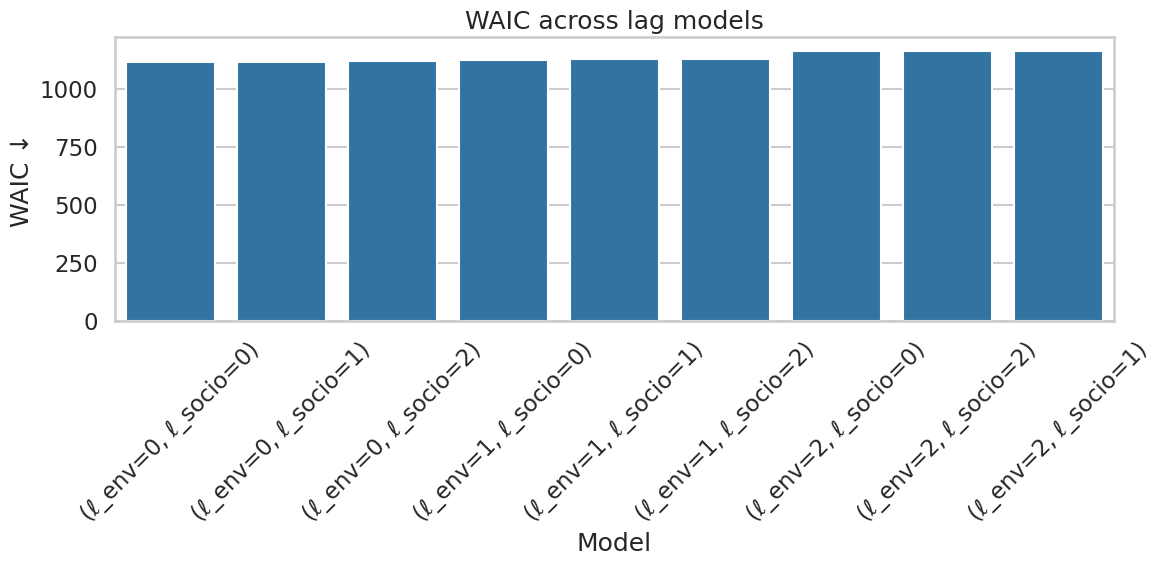

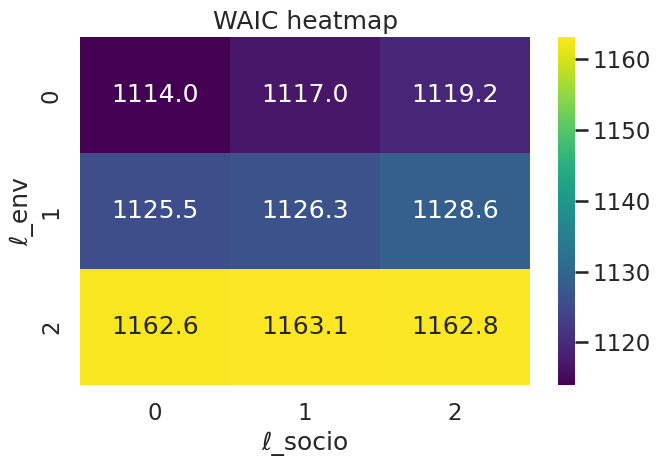

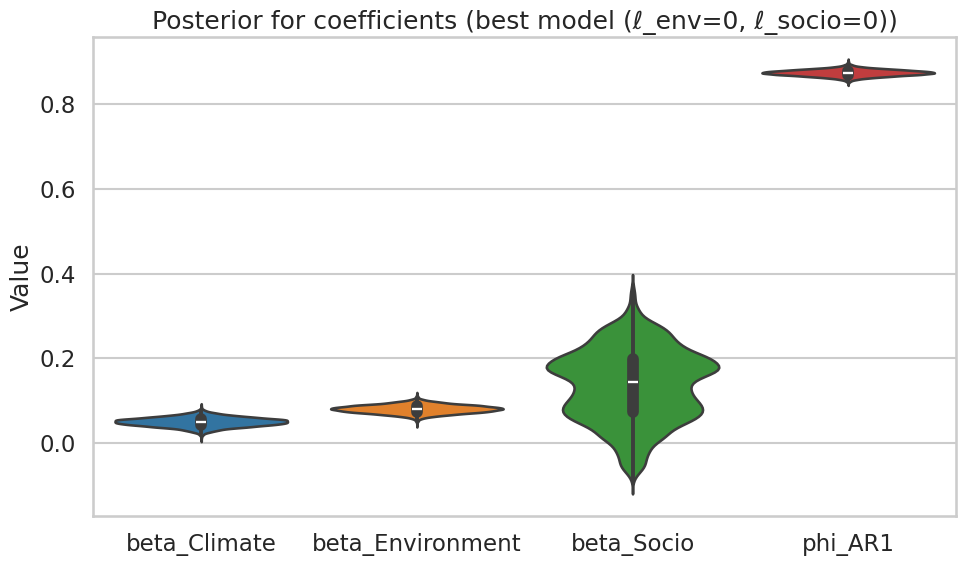

In [10]:
# =========================
# Setup & Imports
# =========================
!pip -q install arviz seaborn

import os, json, math, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sns.set_context("talk"); sns.set_style("whitegrid")

# =========================
# Config
# =========================
DATA_PATH = "Base_Datos_Bolivia_final.csv"  # <-- put your CSV in the Colab working dir
RESULT_DIR = "hsem_modelsel"
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(f"{RESULT_DIR}/raw", exist_ok=True)
os.makedirs(f"{RESULT_DIR}/summary", exist_ok=True)

# Column name guesses (robust to Spanish/English variants). Adjust if needed.
COLUMN_GUESS = {
    "region":  ["departamento","department","dept","adm1","ADM1","Departamento"],
    "year":    ["year","Year","anio","año","Anio","Año"],
    "cases":   ["cases","Casos","dengue_cases","Dengue","Dengue_Casos","Dengue_casos","dengue"],
    "tmax":    ["Temperatura_Maxima","TempMax","Tmax","tmax","Temp_Max","Temperatura Máxima","Temperatura_Máxima"],
    "tmin":    ["Temperatura_Minima","TempMin","Tmin","tmin","Temp_Min","Temperatura Mínima","Temperatura_Mínima"],
    "precip":  ["Precipitacion","Precip","precip","Precipitación","Precipitaci\u00f3n","Precipitación"],
    "ndvi":    ["NDVI","ndvi"],
    "pop":     ["poblacion","Poblacion","population","Population","Pop","POP","población","poblaci\u00f3n"]
}

MAX_LAG = 2   # we consider ℓ_env, ℓ_socio in {0,1,2}
N_ITER  = 20000
BURN    = 5000
SEED    = 2025

PRIOR = {
    "a0": 2.0, "b0": 2.0,    # IG(a0,b0) for variances
    "tau_beta": 1.0          # N(0, tau_beta I) for regression coefs
}

np.random.seed(SEED)

# =========================
# Helpers
# =========================
def pick_col(df, candidates, required=False):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise ValueError(f"Required column missing. None of {candidates} found in df.columns={list(df.columns)}")
    return None

def zscore(x):
    x = x.astype(float)
    mu = np.nanmean(x)
    sd = np.nanstd(x, ddof=1)
    if sd == 0 or np.isnan(sd):
        return np.zeros_like(x, dtype=float)
    return (x - mu)/sd

def make_panel(df):
    # pick columns (robust)
    c_region = pick_col(df, COLUMN_GUESS["region"], required=True)
    c_year   = pick_col(df, COLUMN_GUESS["year"],   required=True)
    c_cases  = pick_col(df, COLUMN_GUESS["cases"],  required=True)
    c_tmax   = pick_col(df, COLUMN_GUESS["tmax"])
    c_tmin   = pick_col(df, COLUMN_GUESS["tmin"])
    c_prec   = pick_col(df, COLUMN_GUESS["precip"])
    c_ndvi   = pick_col(df, COLUMN_GUESS["ndvi"])
    c_pop    = pick_col(df, COLUMN_GUESS["pop"])

    sub = df[[c_region, c_year, c_cases]].copy()
    sub.rename(columns={c_region:"region", c_year:"year", c_cases:"cases"}, inplace=True)

    # Optional indicators
    if c_tmax: sub["tmax"] = df[c_tmax]
    if c_tmin: sub["tmin"] = df[c_tmin]
    if c_prec: sub["precip"] = df[c_prec]
    if c_ndvi: sub["ndvi"] = df[c_ndvi]
    if c_pop:  sub["pop"]  = df[c_pop]

    # Clean region/year
    sub = sub.dropna(subset=["region","year"]).copy()
    sub["year"] = sub["year"].astype(int)
    sub = sub.sort_values(["region","year"]).reset_index(drop=True)

    # make numeric and handle NaNs
    for c in ["cases","tmax","tmin","precip","ndvi","pop"]:
        if c in sub.columns:
            sub[c] = pd.to_numeric(sub[c], errors="coerce")

    # Standardize indicators
    sub["z_cases"] = zscore(np.log1p(sub["cases"].fillna(0.0)))
    if "tmax" in sub:   sub["z_tmax"]   = zscore(sub["tmax"])
    if "tmin" in sub:   sub["z_tmin"]   = zscore(sub["tmin"])
    if "precip" in sub: sub["z_precip"] = zscore(sub["precip"])
    if "ndvi" in sub:   sub["z_ndvi"]   = zscore(sub["ndvi"])
    if "pop" in sub:    sub["z_pop"]    = zscore(sub["pop"])

    # Marker-variable factor scores (proxies)
    # Climate factor := z_tmax (marker). If missing, try average of available climate indicators.
    if "z_tmax" in sub:
        sub["f_climate"] = sub["z_tmax"]
    else:
        # fallback: average of any available climate indicators
        cols = [c for c in ["z_tmax","z_tmin","z_precip"] if c in sub.columns]
        if len(cols)==0:
            raise ValueError("No climate indicators found to form climate factor.")
        sub["f_climate"] = zscore(sub[cols].mean(axis=1))

    # Environment factor := z_ndvi (marker if present), else zeros
    if "z_ndvi" in sub:
        sub["f_env"] = sub["z_ndvi"]
    else:
        sub["f_env"] = 0.0

    # Socio factor := z_pop (marker if present), else zeros
    if "z_pop" in sub:
        sub["f_socio"] = sub["z_pop"]
    else:
        sub["f_socio"] = 0.0

    # Build z_lag within region
    sub["z_lag"] = sub.groupby("region")["z_cases"].shift(1)

    # Drop first MAX_LAG years per region so all models use the same rows (fair comparison)
    sub["rank_t"] = sub.groupby("region")["year"].rank(method="first").astype(int)
    panel = sub.loc[sub["rank_t"]>MAX_LAG].copy().reset_index(drop=True)

    # Encode region/year ids for random effects
    panel["region_id"] = panel["region"].astype("category").cat.codes.values
    panel["year_id"]   = panel["year"].astype("category").cat.codes.values

    return panel

# Gibbs for Bayesian LMM: z ~ X beta + u_region + v_year + e
def gibbs_bmlm(y, X, region_id, year_id, n_regions, n_years, n_iter=20000, burn=5000, prior=None, seed=2025):
    rng = np.random.default_rng(seed)
    a0 = prior.get("a0", 2.0); b0 = prior.get("b0", 2.0)
    tau_beta = prior.get("tau_beta", 1.0)

    N, P = X.shape
    # Precompute per-group indices
    idx_by_region = [np.where(region_id==i)[0] for i in range(n_regions)]
    idx_by_year   = [np.where(year_id==t)[0] for t in range(n_years)]
    n_i = np.array([len(idx) for idx in idx_by_region])
    n_t = np.array([len(idx) for idx in idx_by_year])

    # Init
    beta = np.zeros(P)
    u = np.zeros(n_regions)
    v = np.zeros(n_years)
    s2_e = 1.0
    s2_u = 1.0
    s2_v = 1.0

    S_keep = n_iter - burn
    beta_draws = np.empty((S_keep, P))
    s2_e_draws = np.empty(S_keep)
    s2_u_draws = np.empty(S_keep)
    s2_v_draws = np.empty(S_keep)
    u_draws    = np.empty((S_keep, n_regions))
    v_draws    = np.empty((S_keep, n_years))
    loglik_store = np.empty((S_keep, N))  # pointwise log-lik

    # Precompute
    I = np.eye(P)
    s = 0
    for it in range(n_iter):
        # --- beta | rest ---
        y_tilde = y - u[region_id] - v[year_id]
        XtX = X.T @ X
        XtY = X.T @ y_tilde
        Sigma_post = np.linalg.inv(XtX / s2_e + (1.0/tau_beta) * I)
        mu_post = Sigma_post @ (XtY / s2_e)
        beta = rng.multivariate_normal(mu_post, Sigma_post)

        # --- u | rest ---
        resid_u = y - (X @ beta) - v[year_id]
        for i in range(n_regions):
            idx = idx_by_region[i]
            denom = (1.0/s2_u) + n_i[i]/s2_e
            var_ui = 1.0/denom
            mean_ui = var_ui * (np.sum(resid_u[idx]) / s2_e)
            u[i] = rng.normal(mean_ui, math.sqrt(var_ui))
        # --- v | rest ---
        resid_v = y - (X @ beta) - u[region_id]
        for t in range(n_years):
            idx = idx_by_year[t]
            denom = (1.0/s2_v) + n_t[t]/s2_e
            var_vt = 1.0/denom
            mean_vt = var_vt * (np.sum(resid_v[idx]) / s2_e)
            v[t] = rng.normal(mean_vt, math.sqrt(var_vt))

        # --- variances ---
        resid = y - (X @ beta) - u[region_id] - v[year_id]
        a_e = a0 + N/2.0
        b_e = b0 + 0.5*np.sum(resid**2)
        s2_e = 1.0 / rng.gamma(a_e, 1.0/b_e)

        a_u = a0 + n_regions/2.0
        b_u = b0 + 0.5*np.sum(u**2)
        s2_u = 1.0 / rng.gamma(a_u, 1.0/b_u)

        a_v = a0 + n_years/2.0
        b_v = b0 + 0.5*np.sum(v**2)
        s2_v = 1.0 / rng.gamma(a_v, 1.0/b_v)

        # --- store ---
        if it >= burn:
            mu = (X @ beta) + u[region_id] + v[year_id]
            ll = -0.5*np.log(2*np.pi*s2_e) - 0.5*((y-mu)**2)/s2_e
            loglik_store[s, :] = ll
            beta_draws[s, :] = beta
            s2_e_draws[s] = s2_e
            s2_u_draws[s] = s2_u
            s2_v_draws[s] = s2_v
            u_draws[s, :]  = u
            v_draws[s, :]  = v
            s += 1

    out = dict(beta=beta_draws, s2_e=s2_e_draws, s2_u=s2_u_draws, s2_v=s2_v_draws,
               u=u_draws, v=v_draws, loglik=loglik_store)
    return out

def _logsumexp(a, axis=None):
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

def compute_waic(loglik_SxN):
    S, N = loglik_SxN.shape
    lppd_i = _logsumexp(loglik_SxN, axis=0) - np.log(S)
    p_waic_i = np.var(loglik_SxN, axis=0, ddof=1)
    lppd = np.sum(lppd_i)
    p_waic = np.sum(p_waic_i)
    waic = -2.0 * (lppd - p_waic)
    waic_i = -2.0 * (lppd_i - p_waic_i)
    se_waic = np.sqrt(np.var(waic_i, ddof=1) * N)
    return dict(waic=waic, p_waic=p_waic, lppd=lppd, se_waic=se_waic,
                lppd_i=lppd_i, p_waic_i=p_waic_i, waic_i=waic_i)

def compute_psis_loo_with_arviz(loglik_SxN):
    # shape (chain, draw, obs) -> fake 1 chain
    import xarray as xr
    ll = loglik_SxN[np.newaxis, :, :]  # (1,S,N)
    ll_da = xr.DataArray(ll, dims=("chain","draw","obs"))
    idata = az.InferenceData(log_likelihood={"y": ll_da})
    loo_res = az.loo(idata, pointwise=True)
    elpd_loo = float(loo_res.elpd_loo)
    p_loo = float(loo_res.p_loo)
    loo = float(-2.0 * elpd_loo)  # deviance scale
    se = float(loo_res.se)
    df_pw = pd.DataFrame({
        "elpd_loo_i": loo_res.loo_i.values,
        "pareto_k": loo_res.pareto_k.values
    })
    return dict(elpd_loo=elpd_loo, p_loo=p_loo, loo=loo, se=se, pointwise=df_pw)

# =========================
# Load data & panel
# =========================
df_raw = pd.read_csv(DATA_PATH)
panel = make_panel(df_raw)

# =========================
# Build design per (ℓ_env, ℓ_socio)
# =========================
def build_design(panel, ell_env=0, ell_socio=0):
    # Shift factors by lag within region
    df = panel.copy()
    df["f_env_lag"]   = df.groupby("region")["f_env"].shift(ell_env).values
    df["f_socio_lag"] = df.groupby("region")["f_socio"].shift(ell_socio).values

    # Since we already dropped first MAX_LAG years, these should be non-missing for ell<=MAX_LAG
    df = df.dropna(subset=["f_env_lag","f_socio_lag","z_lag","f_climate"]).copy()

    y = df["z_cases"].values.astype(float)
    # Design: [1, climate_t, env_{t-l}, socio_{t-l}, z_{t-1}]
    X = np.column_stack([
        np.ones(len(df)),
        df["f_climate"].values.astype(float),
        df["f_env_lag"].values.astype(float),
        df["f_socio_lag"].values.astype(float),
        df["z_lag"].values.astype(float)
    ])
    region_id = df["region_id"].values
    year_id   = df["year_id"].values
    n_regions = df["region_id"].nunique()
    n_years   = df["year_id"].nunique()
    meta = dict(ell_env=ell_env, ell_socio=ell_socio,
                n=len(df), n_regions=n_regions, n_years=n_years)
    return y, X, region_id, year_id, n_regions, n_years, meta, df

# =========================
# Fit all 9 models, save loglik + summaries
# =========================
all_summ = []
grid = [(le,ls) for le in (0,1,2) for ls in (0,1,2)]

for (ell_env, ell_socio) in grid:
    print(f"Fitting (ℓ_env={ell_env}, ℓ_socio={ell_socio}) ...")
    y, X, rid, yid, nR, nT, meta, dfm = build_design(panel, ell_env, ell_socio)
    fit = gibbs_bmlm(y, X, rid, yid, nR, nT, n_iter=N_ITER, burn=BURN, prior=PRIOR, seed=SEED+ell_env*10+ell_socio)

    # store raw loglik for WAIC/LOO
    np.save(f"{RESULT_DIR}/raw/loglik_lenv{ell_env}_lsoc{ell_socio}.npy", fit["loglik"])
    with open(f"{RESULT_DIR}/raw/meta_lenv{ell_env}_lsoc{ell_socio}.json","w") as f:
        json.dump(meta, f)

    # compute WAIC & LOO
    waic = compute_waic(fit["loglik"])
    try:
        loo  = compute_psis_loo_with_arviz(fit["loglik"])
        loo_err = None
    except Exception as e:
        loo  = dict(elpd_loo=np.nan, p_loo=np.nan, loo=np.nan, se=np.nan, pointwise=None)
        loo_err = str(e)

    summ = dict(
        Model=f"(ℓ_env={ell_env}, ℓ_socio={ell_socio})",
        ell_env=ell_env, ell_socio=ell_socio,
        WAIC=waic["waic"], WAIC_SE=waic["se_waic"], p_WAIC=waic["p_waic"],
        LOO=loo["loo"], LOO_SE=loo["se"], ELPD_LOO=loo["elpd_loo"], P_LOO=loo["p_loo"],
        arviz_error=loo_err
    )
    all_summ.append(summ)

df_summ = pd.DataFrame(all_summ).sort_values(["WAIC","LOO"]).reset_index(drop=True)
df_summ.to_csv(f"{RESULT_DIR}/summary/model_selection_summary.csv", index=False)
print(df_summ)

# =========================
# Plots: Bars, Heatmaps, Violins
# =========================
# Bars
fig, ax = plt.subplots(figsize=(12,6))
order = df_summ.sort_values("WAIC").Model
sns.barplot(data=df_summ, x="Model", y="WAIC", order=order, ax=ax)
ax.set_title("WAIC across lag models"); ax.set_xlabel("Model"); ax.set_ylabel("WAIC ↓")
ax.tick_params(axis='x', rotation=45)
fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/waic_bar.png", dpi=220)

if df_summ["LOO"].notna().any():
    fig, ax = plt.subplots(figsize=(12,6))
    order = df_summ.sort_values("LOO").Model
    sns.barplot(data=df_summ, x="Model", y="LOO", order=order, ax=ax)
    ax.set_title("PSIS-LOO deviance across lag models"); ax.set_xlabel("Model"); ax.set_ylabel("LOO deviance ↓")
    ax.tick_params(axis='x', rotation=45)
    fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/loo_bar.png", dpi=220)

# Heatmaps
pv_w = df_summ.pivot(index="ell_env", columns="ell_socio", values="WAIC")
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(pv_w, annot=True, fmt=".1f", cmap="viridis", ax=ax)
ax.set_title("WAIC heatmap"); ax.set_xlabel("ℓ_socio"); ax.set_ylabel("ℓ_env")
fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/waic_heatmap.png", dpi=220)

if df_summ["LOO"].notna().any():
    pv_l = df_summ.pivot(index="ell_env", columns="ell_socio", values="LOO")
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(pv_l, annot=True, fmt=".1f", cmap="magma", ax=ax)
    ax.set_title("LOO deviance heatmap"); ax.set_xlabel("ℓ_socio"); ax.set_ylabel("ℓ_env")
    fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/loo_heatmap.png", dpi=220)

# Coefficient violins for the BEST model (by WAIC)
best_model = df_summ.iloc[0]
print("Best by WAIC:", best_model["Model"])
# Refit once to extract beta draws for violin plots
y, X, rid, yid, nR, nT, meta, dfm = build_design(panel, int(best_model.ell_env), int(best_model.ell_socio))
fit_best = gibbs_bmlm(y, X, rid, yid, nR, nT, n_iter=N_ITER, burn=BURN, prior=PRIOR, seed=SEED+999)
beta_df = pd.DataFrame(fit_best["beta"], columns=["Intercept","beta_Climate","beta_Environment","beta_Socio","phi_AR1"])

fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(data=beta_df[["beta_Climate","beta_Environment","beta_Socio","phi_AR1"]], inner="box", ax=ax)
ax.set_title(f"Posterior for coefficients (best model {best_model['Model']})")
ax.set_xlabel(""); ax.set_ylabel("Value")
fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/beta_violins_best.png", dpi=220)

# =========================
# LaTeX table
# =========================
with open(f"{RESULT_DIR}/summary/model_selection_summary.tex","w") as f:
    f.write(df_summ.to_latex(index=False, float_format="%.3f",
                             caption="Model comparison over lag grid using WAIC and PSIS-LOO (lower is better).",
                             label="tab:model-selection"))
print(f"\nSaved summary CSV/TeX and plots to: {RESULT_DIR}/summary/")


Fitting (ℓ_env=0, ℓ_socio=0) ...
Fitting (ℓ_env=0, ℓ_socio=1) ...
Fitting (ℓ_env=0, ℓ_socio=2) ...
Fitting (ℓ_env=1, ℓ_socio=0) ...
Fitting (ℓ_env=1, ℓ_socio=1) ...
Fitting (ℓ_env=1, ℓ_socio=2) ...
Fitting (ℓ_env=2, ℓ_socio=0) ...
Fitting (ℓ_env=2, ℓ_socio=1) ...
Fitting (ℓ_env=2, ℓ_socio=2) ...
                  Model  ell_env  ell_socio         WAIC     WAIC_SE  \
0  (ℓ_env=0, ℓ_socio=0)        0          0  1126.711848  139.479882   
1  (ℓ_env=0, ℓ_socio=1)        0          1  1129.628673  139.276607   
2  (ℓ_env=0, ℓ_socio=2)        0          2  1131.892966  139.135206   
3  (ℓ_env=1, ℓ_socio=1)        1          1  1147.117286  139.510679   
4  (ℓ_env=1, ℓ_socio=0)        1          0  1147.198956  139.547318   
5  (ℓ_env=1, ℓ_socio=2)        1          2  1149.542903  139.409826   
6  (ℓ_env=2, ℓ_socio=0)        2          0  1168.633052  139.600089   
7  (ℓ_env=2, ℓ_socio=1)        2          1  1169.382727  139.594504   
8  (ℓ_env=2, ℓ_socio=2)        2          2  1170.35422

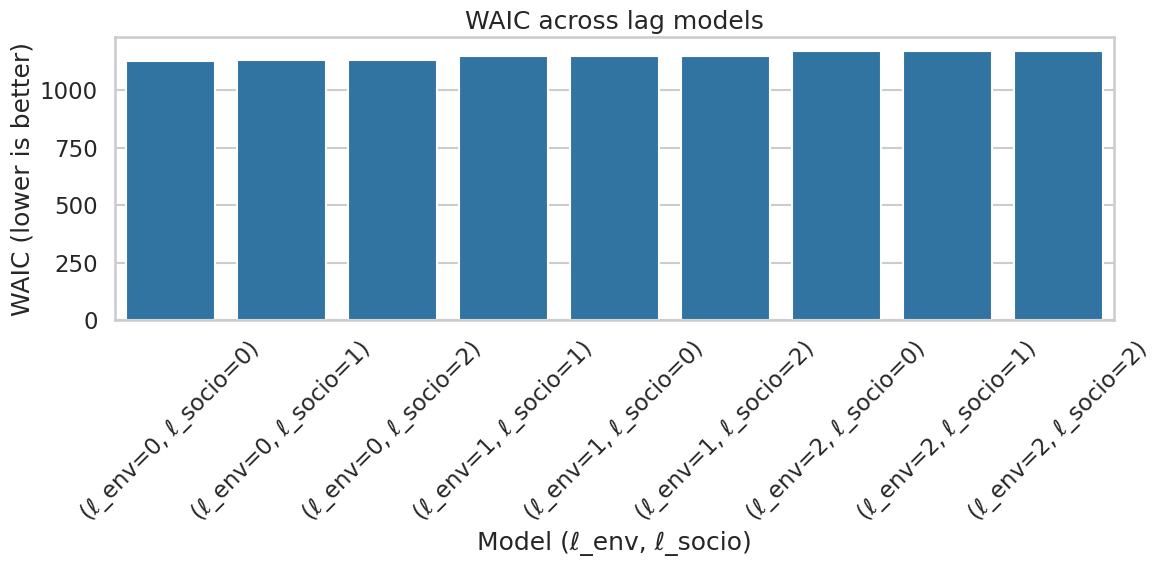

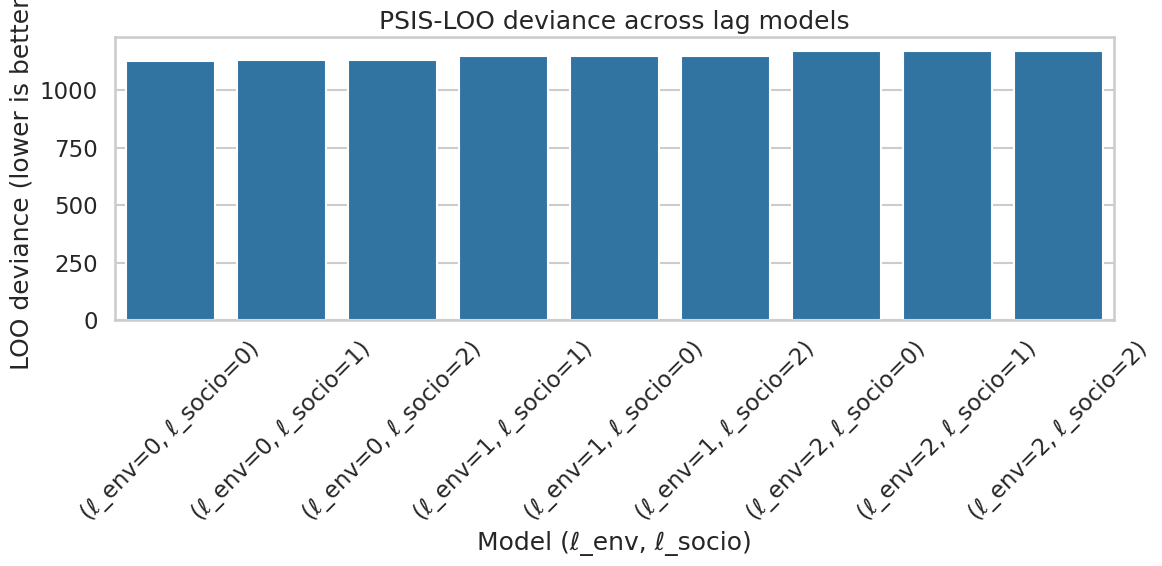

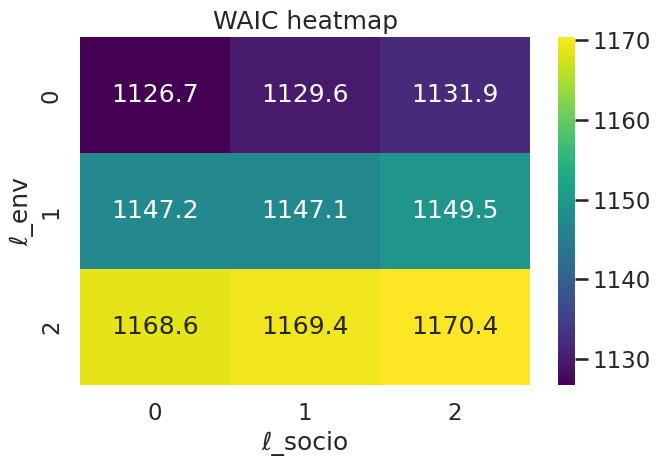

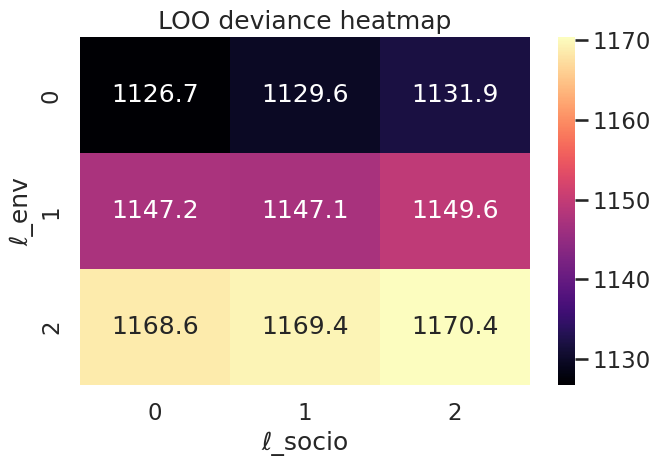

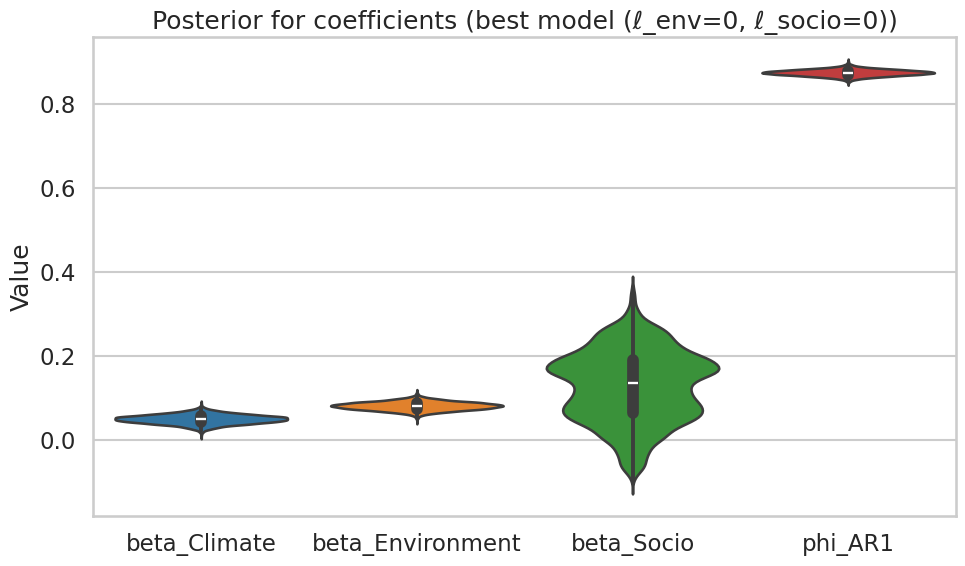

In [11]:
# =========================
# Clean, robust Colab script
#   - Fits Bayesian LMM over lag grid (ℓ_env, ℓ_socio ∈ {0,1,2})
#   - Saves pointwise log-lik per draw
#   - Computes WAIC (always) + PSIS-LOO (manual, robust)
#   - Generates summary CSV/LaTeX + plots
# =========================

# If running in Colab, uncomment:
# !pip -q install arviz seaborn xarray

import os, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import ArviZ's psislw for stable PSIS; fall back to warning if not present
try:
    from arviz.stats import psislw  # arviz >=0.13
except Exception:
    try:
        from arviz.stats.stats import psislw  # older arviz
    except Exception:
        psislw = None

sns.set_context("talk"); sns.set_style("whitegrid")
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# =========================
# Config
# =========================
DATA_PATH = "Base_Datos_Bolivia_final.csv"  # ensure the file is in the working directory
RESULT_DIR = "hsem_modelsel"
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(f"{RESULT_DIR}/raw", exist_ok=True)
os.makedirs(f"{RESULT_DIR}/summary", exist_ok=True)

MAX_LAG = 2                 # we evaluate ℓ_env, ℓ_socio in {0,1,2}
N_ITER  = 20000
BURN    = 5000
SEED    = 2025

PRIOR = {
    "a0": 2.0, "b0": 2.0,   # Inv-Gamma(a0,b0) for variances
    "tau_beta": 1.0         # N(0, tau_beta I) ridge for beta
}

# Column name guesses (adjust if your headers differ)
COLUMN_GUESS = {
    "region":  ["departamento","department","dept","adm1","ADM1","Departamento","Region","region"],
    "year":    ["year","Year","anio","año","Anio","Año","YYYY"],
    "cases":   ["cases","Casos","dengue_cases","Dengue","Dengue_Casos","Dengue_casos","dengue","CASOS"],
    "tmax":    ["Temperatura_Maxima","TempMax","Tmax","tmax","Temp_Max","Temperatura Máxima","Temperatura_Máxima"],
    "tmin":    ["Temperatura_Minima","TempMin","Tmin","tmin","Temp_Min","Temperatura Mínima","Temperatura_Mínima"],
    "precip":  ["Precipitacion","Precip","precip","Precipitación","Precipitaci\u00f3n","Precipitación","PPT","ppt"],
    "ndvi":    ["NDVI","ndvi"],
    "pop":     ["poblacion","Poblacion","population","Population","Pop","POP","población","poblaci\u00f3n"]
}

rng_global = np.random.default_rng(SEED)

# =========================
# Utilities
# =========================
def pick_col(df, candidates, required=False):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise ValueError(f"Required column missing. None of {candidates} found.\nAvailable columns: {list(df.columns)}")
    return None

def zscore(x):
    x = pd.to_numeric(pd.Series(x), errors="coerce").to_numpy()
    mask = np.isfinite(x)
    if not np.any(mask):
        return np.zeros_like(x, dtype=float)
    mu = np.mean(x[mask])
    sd = np.std(x[mask], ddof=1)
    if not np.isfinite(sd) or sd == 0:
        return np.zeros_like(x, dtype=float)
    out = (x - mu)/sd
    out[~np.isfinite(out)] = 0.0
    return out

def make_panel(df):
    # Select columns robustly
    c_region = pick_col(df, COLUMN_GUESS["region"], required=True)
    c_year   = pick_col(df, COLUMN_GUESS["year"],   required=True)
    c_cases  = pick_col(df, COLUMN_GUESS["cases"],  required=True)
    c_tmax   = pick_col(df, COLUMN_GUESS["tmax"])
    c_tmin   = pick_col(df, COLUMN_GUESS["tmin"])
    c_prec   = pick_col(df, COLUMN_GUESS["precip"])
    c_ndvi   = pick_col(df, COLUMN_GUESS["ndvi"])
    c_pop    = pick_col(df, COLUMN_GUESS["pop"])

    sub = df[[c_region, c_year, c_cases]].copy()
    sub.rename(columns={c_region:"region", c_year:"year", c_cases:"cases"}, inplace=True)

    # Optional indicators
    if c_tmax: sub["tmax"] = pd.to_numeric(df[c_tmax], errors="coerce")
    if c_tmin: sub["tmin"] = pd.to_numeric(df[c_tmin], errors="coerce")
    if c_prec: sub["precip"] = pd.to_numeric(df[c_prec], errors="coerce")
    if c_ndvi: sub["ndvi"] = pd.to_numeric(df[c_ndvi], errors="coerce")
    if c_pop:  sub["pop"]  = pd.to_numeric(df[c_pop], errors="coerce")

    # Clean region/year
    sub = sub.dropna(subset=["region","year"]).copy()
    sub["year"] = pd.to_numeric(sub["year"], errors="coerce").astype(int)
    sub = sub.sort_values(["region","year"]).reset_index(drop=True)

    # Standardize outcome and indicators
    sub["z_cases"] = zscore(np.log1p(sub["cases"].fillna(0.0)))
    if "tmax" in sub:   sub["z_tmax"]   = zscore(sub["tmax"])
    if "tmin" in sub:   sub["z_tmin"]   = zscore(sub["tmin"])
    if "precip" in sub: sub["z_precip"] = zscore(sub["precip"])
    if "ndvi" in sub:   sub["z_ndvi"]   = zscore(sub["ndvi"])
    if "pop" in sub:    sub["z_pop"]    = zscore(sub["pop"])

    # Marker-variable proxies for factors (robust)
    # Climate := z_tmax if available; else mean of available climate z-indicators
    if "z_tmax" in sub:
        sub["f_climate"] = sub["z_tmax"]
    else:
        clims = [c for c in ["z_tmin","z_precip"] if c in sub.columns]
        if len(clims) == 0:
            raise ValueError("No climate indicators available to form climate factor.")
        sub["f_climate"] = zscore(sub[clims].mean(axis=1))

    # Environment := z_ndvi if available else zeros (keeps models comparable)
    sub["f_env"] = sub["z_ndvi"] if "z_ndvi" in sub else 0.0

    # Socio := z_pop if available else zeros
    sub["f_socio"] = sub["z_pop"] if "z_pop" in sub else 0.0

    # AR(1) lag within region
    sub["z_lag"] = sub.groupby("region")["z_cases"].shift(1)

    # To ensure all models use the same rows (for ℓ up to MAX_LAG)
    sub["rank_t"] = sub.groupby("region")["year"].rank(method="first").astype(int)
    panel = sub.loc[sub["rank_t"] > MAX_LAG].copy().reset_index(drop=True)

    # Encode ids
    panel["region_id"] = panel["region"].astype("category").cat.codes.values
    panel["year_id"]   = panel["year"].astype("category").cat.codes.values

    # Final finite filter (safety)
    for c in ["z_cases","f_climate","f_env","f_socio","z_lag"]:
        panel[c] = pd.to_numeric(panel[c], errors="coerce")
    panel = panel.replace([np.inf,-np.inf], np.nan).dropna(subset=["z_cases","z_lag"]).reset_index(drop=True)

    return panel

def build_design(panel, ell_env=0, ell_socio=0):
    df = panel.copy()

    # Lags within region (fill NaNs safely before shift)
    for c in ["f_env","f_socio"]:
        if c in df:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

    df["f_env_lag"]   = df.groupby("region")["f_env"].shift(ell_env)
    df["f_socio_lag"] = df.groupby("region")["f_socio"].shift(ell_socio)

    # Drop rows with missing lagged terms or z_lag
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=["f_env_lag","f_socio_lag","z_lag"]).copy()

    # Construct outcome and design (Intercept, Climate_t, Env_{t-ℓe}, Socio_{t-ℓs}, z_{t-1})
    y = pd.to_numeric(df["z_cases"], errors="coerce").to_numpy(dtype=float)
    X = np.column_stack([
        np.ones(len(df)),
        pd.to_numeric(df["f_climate"], errors="coerce").to_numpy(dtype=float),
        pd.to_numeric(df["f_env_lag"], errors="coerce").to_numpy(dtype=float),
        pd.to_numeric(df["f_socio_lag"], errors="coerce").to_numpy(dtype=float),
        pd.to_numeric(df["z_lag"], errors="coerce").to_numpy(dtype=float)
    ])

    # Ensure finite values only
    mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
    y, X = y[mask], X[mask]
    df = df.iloc[np.where(mask)[0]].reset_index(drop=True)

    region_id = df["region_id"].to_numpy()
    year_id   = df["year_id"].to_numpy()
    n_regions = int(df["region_id"].nunique())
    n_years   = int(df["year_id"].nunique())
    meta = dict(ell_env=int(ell_env), ell_socio=int(ell_socio),
                n=int(len(df)), n_regions=n_regions, n_years=n_years)
    return y, X, region_id, year_id, n_regions, n_years, meta, df

# Bayesian LMM via conjugate Gibbs
def gibbs_bmlm(y, X, region_id, year_id, n_regions, n_years,
               n_iter=20000, burn=5000, prior=None, seed=2025):
    rng = np.random.default_rng(seed)
    a0 = prior.get("a0", 2.0); b0 = prior.get("b0", 2.0)
    tau_beta = prior.get("tau_beta", 1.0)

    N, P = X.shape
    # group indices
    idx_by_region = [np.where(region_id==i)[0] for i in range(n_regions)]
    idx_by_year   = [np.where(year_id==t)[0] for t in range(n_years)]
    n_i = np.array([len(idx) for idx in idx_by_region])
    n_t = np.array([len(idx) for idx in idx_by_year])

    # Initialize
    beta = np.zeros(P)
    u = np.zeros(n_regions)
    v = np.zeros(n_years)
    s2_e = 1.0
    s2_u = 1.0
    s2_v = 1.0

    S_keep = max(0, n_iter - burn)
    beta_draws = np.empty((S_keep, P))
    s2_e_draws = np.empty(S_keep)
    s2_u_draws = np.empty(S_keep)
    s2_v_draws = np.empty(S_keep)
    u_draws    = np.empty((S_keep, n_regions))
    v_draws    = np.empty((S_keep, n_years))
    loglik_store = np.empty((S_keep, N))  # pointwise log-lik

    I = np.eye(P)
    s = 0

    # Precomputations
    XtX = X.T @ X
    Xt = X.T

    for it in range(n_iter):
        # --- beta | rest ---
        y_tilde = y - u[region_id] - v[year_id]
        # posterior precision = XtX/s2_e + I/tau_beta
        Prec = XtX / s2_e + I / tau_beta
        try:
            # solve for Sigma_post via Cholesky for stability
            L = np.linalg.cholesky(Prec)
            Linv = np.linalg.inv(L)
            Sigma_post = Linv.T @ Linv
        except np.linalg.LinAlgError:
            Sigma_post = np.linalg.pinv(Prec)
        mu_post = Sigma_post @ (Xt @ y_tilde) / s2_e
        beta = rng.multivariate_normal(mu_post, Sigma_post)

        # --- u | rest ---
        resid_u = y - (X @ beta) - v[year_id]
        for i in range(n_regions):
            idx = idx_by_region[i]
            denom = (1.0/s2_u) + n_i[i]/s2_e
            var_ui = 1.0 / denom
            mean_ui = var_ui * (np.sum(resid_u[idx]) / s2_e)
            u[i] = rng.normal(mean_ui, math.sqrt(max(var_ui, 1e-12)))

        # --- v | rest ---
        resid_v = y - (X @ beta) - u[region_id]
        for t in range(n_years):
            idx = idx_by_year[t]
            denom = (1.0/s2_v) + n_t[t]/s2_e
            var_vt = 1.0 / denom
            mean_vt = var_vt * (np.sum(resid_v[idx]) / s2_e)
            v[t] = rng.normal(mean_vt, math.sqrt(max(var_vt, 1e-12)))

        # --- variances (IG) ---
        resid = y - (X @ beta) - u[region_id] - v[year_id]
        a_e = a0 + N/2.0
        b_e = b0 + 0.5*np.sum(resid**2)
        s2_e = 1.0 / rng.gamma(shape=a_e, scale=1.0/max(b_e, 1e-12))  # gamma(shape, scale)

        a_u = a0 + n_regions/2.0
        b_u = b0 + 0.5*np.sum(u**2)
        s2_u = 1.0 / rng.gamma(shape=a_u, scale=1.0/max(b_u, 1e-12))

        a_v = a0 + n_years/2.0
        b_v = b0 + 0.5*np.sum(v**2)
        s2_v = 1.0 / rng.gamma(shape=a_v, scale=1.0/max(b_v, 1e-12))

        # --- store ---
        if it >= burn:
            mu = (X @ beta) + u[region_id] + v[year_id]
            # Ensure finite s2_e
            s2_e_safe = float(s2_e) if (s2_e > 0 and np.isfinite(s2_e)) else 1.0
            ll = -0.5*np.log(2*np.pi*s2_e_safe) - 0.5*((y-mu)**2)/s2_e_safe

            # Guard against any non-finite residuals
            ll = np.where(np.isfinite(ll), ll, -1e6)

            loglik_store[s, :] = ll
            beta_draws[s, :] = beta
            s2_e_draws[s] = s2_e_safe
            s2_u_draws[s] = s2_u
            s2_v_draws[s] = s2_v
            u_draws[s, :]  = u
            v_draws[s, :]  = v
            s += 1

    out = dict(beta=beta_draws, s2_e=s2_e_draws, s2_u=s2_u_draws, s2_v=s2_v_draws,
               u=u_draws, v=v_draws, loglik=loglik_store)
    return out

# WAIC
def _logsumexp(a, axis=None):
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

def compute_waic(loglik_SxN):
    S, N = loglik_SxN.shape
    # Replace any -inf (from guards) with large negative finite values for stability
    loglik = np.where(np.isfinite(loglik_SxN), loglik_SxN, -1e6)
    lppd_i = _logsumexp(loglik, axis=0) - np.log(S)
    p_waic_i = np.var(loglik, axis=0, ddof=1)
    lppd = float(np.sum(lppd_i))
    p_waic = float(np.sum(p_waic_i))
    waic = -2.0 * (lppd - p_waic)
    waic_i = -2.0 * (lppd_i - p_waic_i)
    se_waic = float(np.sqrt(np.var(waic_i, ddof=1) * N))
    return dict(waic=waic, p_waic=p_waic, lppd=lppd, se_waic=se_waic,
                lppd_i=lppd_i, p_waic_i=p_waic_i, waic_i=waic_i)

# Manual PSIS-LOO (robust, no InferenceData needed)
def compute_psis_loo_manual(loglik_SxN):
    if psislw is None:
        return dict(loo=np.nan, se=np.nan, elpd_loo=np.nan, p_loo=np.nan,
                    elpd_loo_i=None, pareto_k=None, error="arviz.psislw not available")
    S, N = loglik_SxN.shape
    loglik = np.where(np.isfinite(loglik_SxN), loglik_SxN, -1e6)

    elpd_loo_i = np.empty(N)
    pareto_k = np.empty(N)
    # For p_loo, we need lppd_i as in WAIC
    lppd_i = _logsumexp(loglik, axis=0) - np.log(S)

    for i in range(N):
        ll_i = loglik[:, i]
        # raw log importance weights: log r_s = -log p(y_i|theta_s) = -ll_i
        lw_raw = -ll_i
        lw_stable, k = psislw(lw_raw)  # stabilized log-weights (unnormalized)
        pareto_k[i] = float(k)

        # elpd_loo_i = logsumexp(lw + ll) - logsumexp(lw)
        num = _logsumexp(lw_stable + ll_i, axis=0)
        den = _logsumexp(lw_stable, axis=0)
        elpd_loo_i[i] = float(num - den)

    elpd_loo = float(np.sum(elpd_loo_i))
    loo = -2.0 * elpd_loo
    # Effective number of parameters for LOO
    p_loo_i = lppd_i - elpd_loo_i
    p_loo = float(np.sum(p_loo_i))
    se = float(np.sqrt(N * np.var(elpd_loo_i, ddof=1)))
    return dict(loo=loo, se=se, elpd_loo=elpd_loo, p_loo=p_loo,
                elpd_loo_i=elpd_loo_i, pareto_k=pareto_k, error=None)

# =========================
# Load data & prepare panel
# =========================
df_raw = pd.read_csv(DATA_PATH)
panel = make_panel(df_raw)

# =========================
# Fit all 9 models
# =========================
all_summ = []
grid = [(le,ls) for le in (0,1,2) for ls in (0,1,2)]

for (ell_env, ell_socio) in grid:
    print(f"Fitting (ℓ_env={ell_env}, ℓ_socio={ell_socio}) ...")
    y, X, rid, yid, nR, nT, meta, dfm = build_design(panel, ell_env, ell_socio)

    # Guard: if no rows, skip
    if len(y) == 0:
        print(f"[WARN] No rows after lagging for (ℓ_env={ell_env}, ℓ_socio={ell_socio}). Skipping.")
        continue

    fit = gibbs_bmlm(y, X, rid, yid, nR, nT, n_iter=N_ITER, burn=BURN, prior=PRIOR,
                     seed=SEED + 100*ell_env + ell_socio)

    # Save raw log-lik and meta
    np.save(f"{RESULT_DIR}/raw/loglik_lenv{ell_env}_lsoc{ell_socio}.npy", fit["loglik"])
    with open(f"{RESULT_DIR}/raw/meta_lenv{ell_env}_lsoc{ell_socio}.json","w") as f:
        json.dump(meta, f)

    # Scores
    waic = compute_waic(fit["loglik"])
    loo  = compute_psis_loo_manual(fit["loglik"])

    summ = dict(
        Model=f"(ℓ_env={ell_env}, ℓ_socio={ell_socio})",
        ell_env=ell_env, ell_socio=ell_socio,
        WAIC=waic["waic"], WAIC_SE=waic["se_waic"], p_WAIC=waic["p_waic"],
        LOO=loo["loo"], LOO_SE=loo["se"], ELPD_LOO=loo["elpd_loo"], P_LOO=loo["p_loo"],
        arviz_error=loo.get("error", None)
    )
    all_summ.append(summ)

df_summ = pd.DataFrame(all_summ).sort_values(["WAIC","LOO"]).reset_index(drop=True)
df_summ.to_csv(f"{RESULT_DIR}/summary/model_selection_summary.csv", index=False)
print(df_summ)

# =========================
# Plots: Bars, Heatmaps, Violins
# =========================
sns.set_context("talk"); sns.set_style("whitegrid")

# Bars (WAIC)
if not df_summ.empty:
    fig, ax = plt.subplots(figsize=(12,6))
    order = df_summ.sort_values("WAIC").Model
    sns.barplot(data=df_summ, x="Model", y="WAIC", order=order, ax=ax)
    ax.set_title("WAIC across lag models")
    ax.set_xlabel("Model (ℓ_env, ℓ_socio)")
    ax.set_ylabel("WAIC (lower is better)")
    ax.tick_params(axis='x', rotation=45)
    fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/waic_bar.png", dpi=220)

    # Bars (LOO), if available
    if np.isfinite(df_summ["LOO"]).any():
        fig, ax = plt.subplots(figsize=(12,6))
        order = df_summ.sort_values("LOO").Model
        sns.barplot(data=df_summ, x="Model", y="LOO", order=order, ax=ax)
        ax.set_title("PSIS-LOO deviance across lag models")
        ax.set_xlabel("Model (ℓ_env, ℓ_socio)")
        ax.set_ylabel("LOO deviance (lower is better)")
        ax.tick_params(axis='x', rotation=45)
        fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/loo_bar.png", dpi=220)

    # Heatmaps
    try:
        pv_w = df_summ.pivot(index="ell_env", columns="ell_socio", values="WAIC")
        fig, ax = plt.subplots(figsize=(7,5))
        sns.heatmap(pv_w, annot=True, fmt=".1f", cmap="viridis", ax=ax)
        ax.set_title("WAIC heatmap"); ax.set_xlabel("ℓ_socio"); ax.set_ylabel("ℓ_env")
        fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/waic_heatmap.png", dpi=220)
    except Exception:
        pass

    try:
        if np.isfinite(df_summ["LOO"]).any():
            pv_l = df_summ.pivot(index="ell_env", columns="ell_socio", values="LOO")
            fig, ax = plt.subplots(figsize=(7,5))
            sns.heatmap(pv_l, annot=True, fmt=".1f", cmap="magma", ax=ax)
            ax.set_title("LOO deviance heatmap"); ax.set_xlabel("ℓ_socio"); ax.set_ylabel("ℓ_env")
            fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/loo_heatmap.png", dpi=220)
    except Exception:
        pass

    # Refit best model for coefficient violins
    best_model = df_summ.iloc[0]
    print("Best by WAIC:", best_model["Model"])
    y, X, rid, yid, nR, nT, meta, dfm = build_design(panel, int(best_model.ell_env), int(best_model.ell_socio))
    fit_best = gibbs_bmlm(y, X, rid, yid, nR, nT, n_iter=N_ITER, burn=BURN, prior=PRIOR, seed=SEED+999)

    beta_df = pd.DataFrame(fit_best["beta"], columns=["Intercept","beta_Climate","beta_Environment","beta_Socio","phi_AR1"])
    fig, ax = plt.subplots(figsize=(10,6))
    sns.violinplot(data=beta_df[["beta_Climate","beta_Environment","beta_Socio","phi_AR1"]], inner="box", ax=ax)
    ax.set_title(f"Posterior for coefficients (best model {best_model['Model']})")
    ax.set_xlabel(""); ax.set_ylabel("Value")
    fig.tight_layout(); fig.savefig(f"{RESULT_DIR}/summary/beta_violins_best.png", dpi=220)

# =========================
# LaTeX Table
# =========================
with open(f"{RESULT_DIR}/summary/model_selection_summary.tex","w") as f:
    f.write(df_summ.to_latex(index=False, float_format="%.3f",
                             caption="Model comparison over lag grid using WAIC and PSIS-LOO (lower is better).",
                             label="tab:model-selection"))

print(f"\nSaved summary CSV/TeX and plots to: {RESULT_DIR}/summary/")
